In [1]:
import torch

In [189]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import show 
import matplotlib.image as mpimg 
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.widgets import TextBox




In [68]:
import scipy.io as sio
from scipy.interpolate import interp1d
import scipy


import os


import matplotlib.cm as cm


# Retrieve pickle and csv data

In [20]:
# to retrieve  csv##
## but how do I do to retrieve all the files? if i change in for loop the csv fle, but how do i name it?
#df_recruitment_emSim_i_root_i = pd.read_csv('/Volumes/Extreme_SSD/Projectome_Estimation/root_simulations/Processed_12_2022/recruitment_sim_E15_root_S4_DR.csv')


# thus for now we continue with pickle file




with open('/Volumes/Extreme_SSD/Projectome_Estimation/root_simulations/recruitment_simulation_dump.pkl', 'rb') as handle:
    recruitment_simulation = pickle.load(handle)


df_electrodes_for_roots=pd.read_csv('/Volumes/Extreme_SSD/Projectome_Estimation/root_simulations/df_electrodes_for_roots.csv')
electrodes_from_listing=list(df_electrodes_for_roots["electrode_name"])
df_roots=pd.read_csv('/Volumes/Extreme_SSD/Projectome_Estimation/root_simulations/df_roots.csv')
roots=list(df_roots["root_name"])


In [57]:
roots_left=['T12_DL','L1_DL','L2_DL','L3_DL','L4_DL','L5_DL','S1_DL','S2_DL','S3_DL','S4_DL']
roots_right=['T12_DR','L1_DR','L2_DR','L3_DR','L4_DR','L5_DR','S1_DR','S2_DR','S3_DR','S4_DR']

In [55]:
recruitment_simulation[f"_{electrodes_from_listing[0]}_{roots[0]}"][20:30]

Trit_Array  Recruitment    Root EM_Sim Spinal_Level Quadrant
20   86.726010         0.66  T12_DL    E00          T12       DR
21   89.856061         0.68  T12_DL    E00          T12       DR
22   92.986111         0.74  T12_DL    E00          T12       DR
23   96.116162         0.76  T12_DL    E00          T12       DR
24   99.246212         0.78  T12_DL    E00          T12       DR
25  102.376263         0.84  T12_DL    E00          T12       DR
26  105.506313         0.84  T12_DL    E00          T12       DR
27  108.636364         0.86  T12_DL    E00          T12       DR
28  111.766414         0.88  T12_DL    E00          T12       DR
29  114.896465         0.90  T12_DL    E00          T12       DR

# Save figure

In [311]:

def save_figure(folder_name, data_file):
    """
    A function to get the number for the heatmap by by taking the  electric current at the point where afferent recruitment reaches 100%.
    
    Parameters
    ----------
    folder_name
        which folder should it be saved to? eg. recruitment/roots
    data_file
        name of plot
    """
    data_folder = f"/Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/"
    save_folder = os.path.join(data_folder,folder_name)
    os.makedirs(save_folder,exist_ok=True)
    data_file_path = os.path.join(save_folder,data_file)
    plt.savefig(data_file_path, transparent = "False",  
    facecolor='w'
            )

# Plot the simulations (recruitment curve)

-Plot per electrode
-x axis 0-100
-y axis recruitment

separate right and left roots

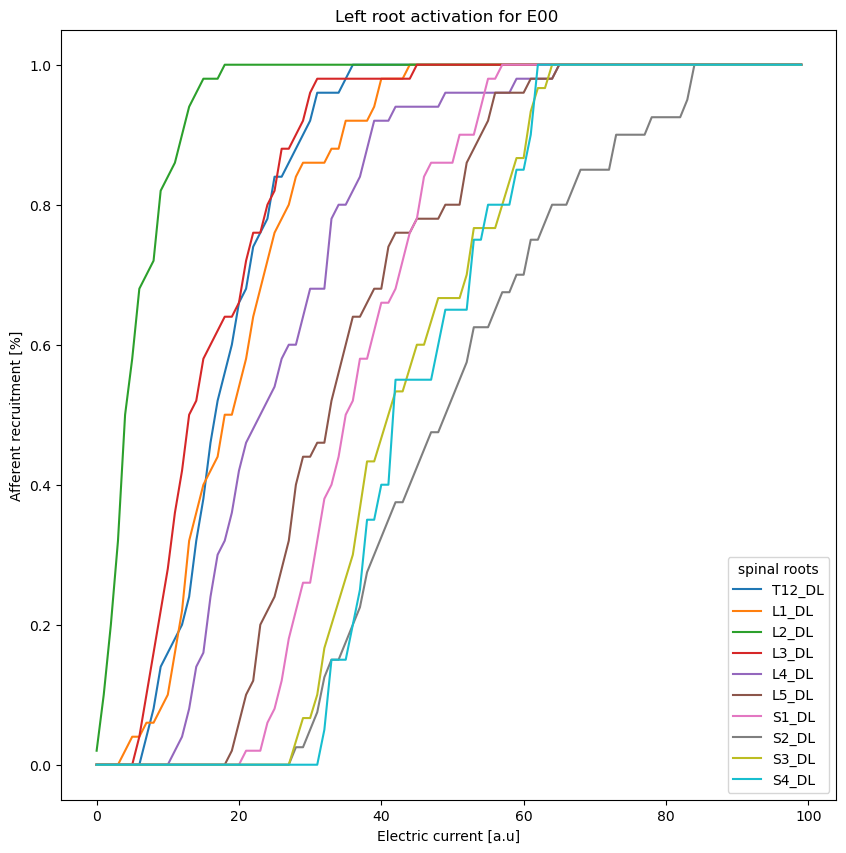

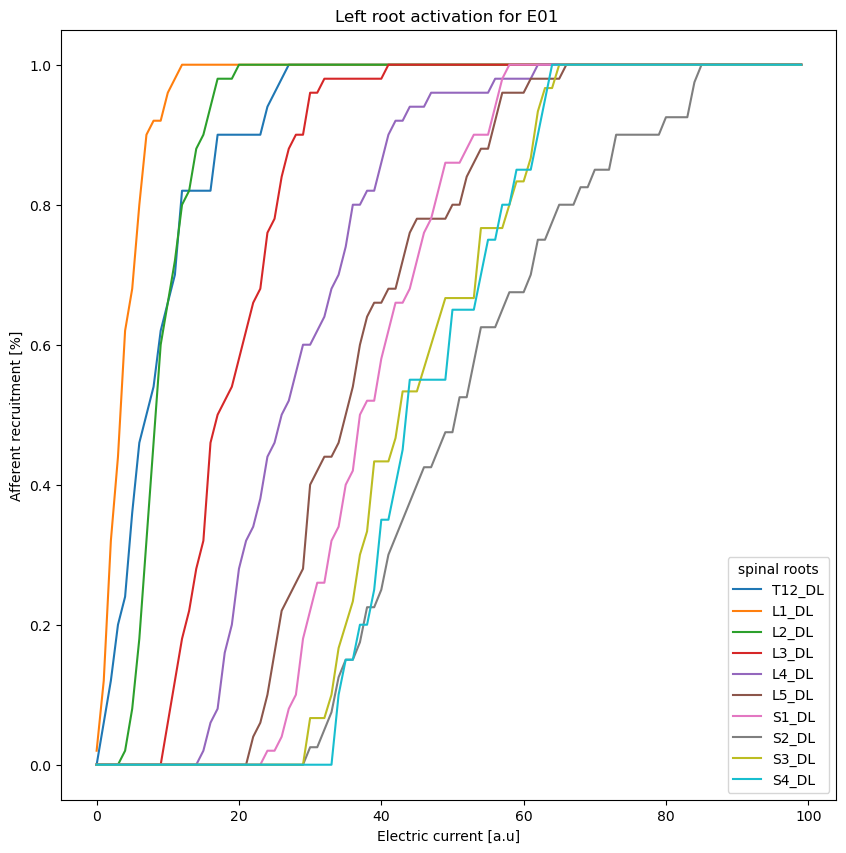

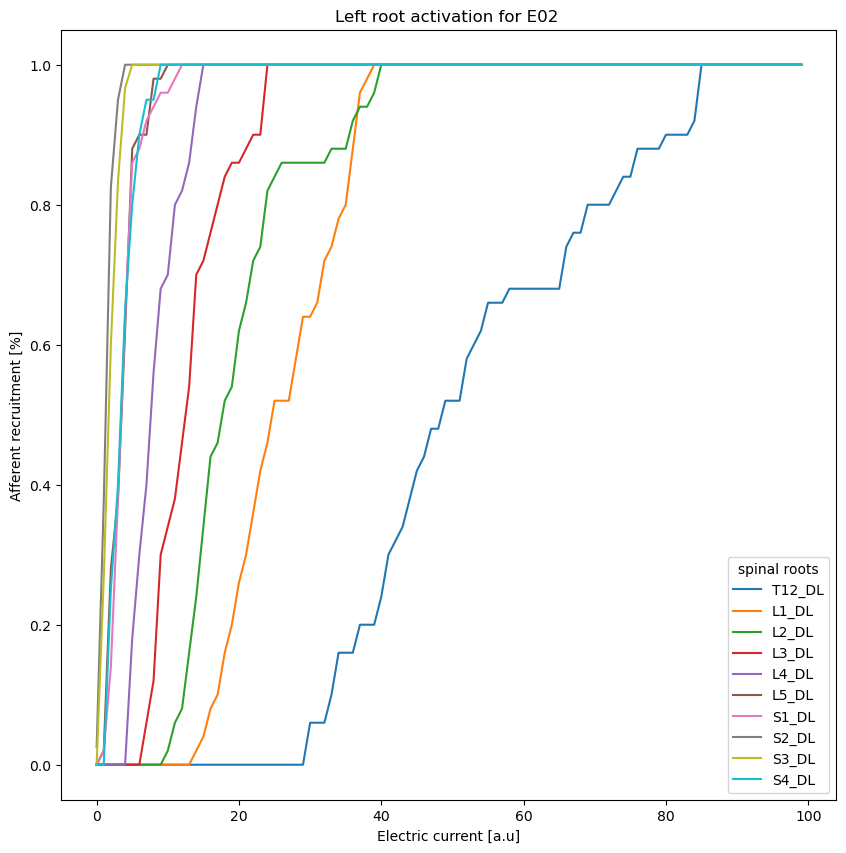

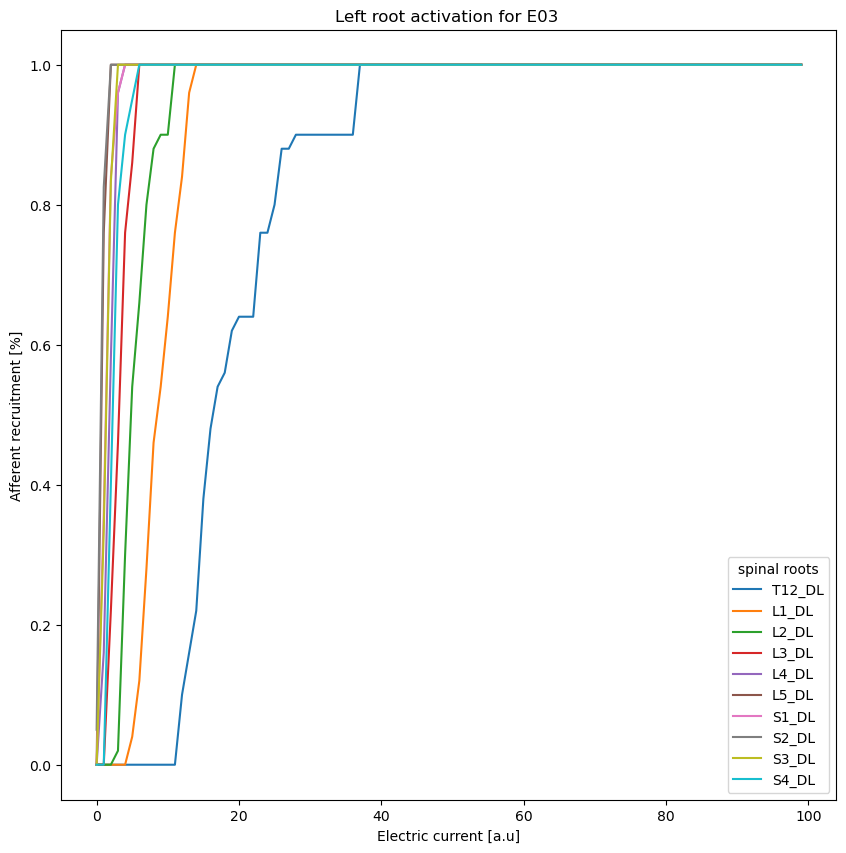

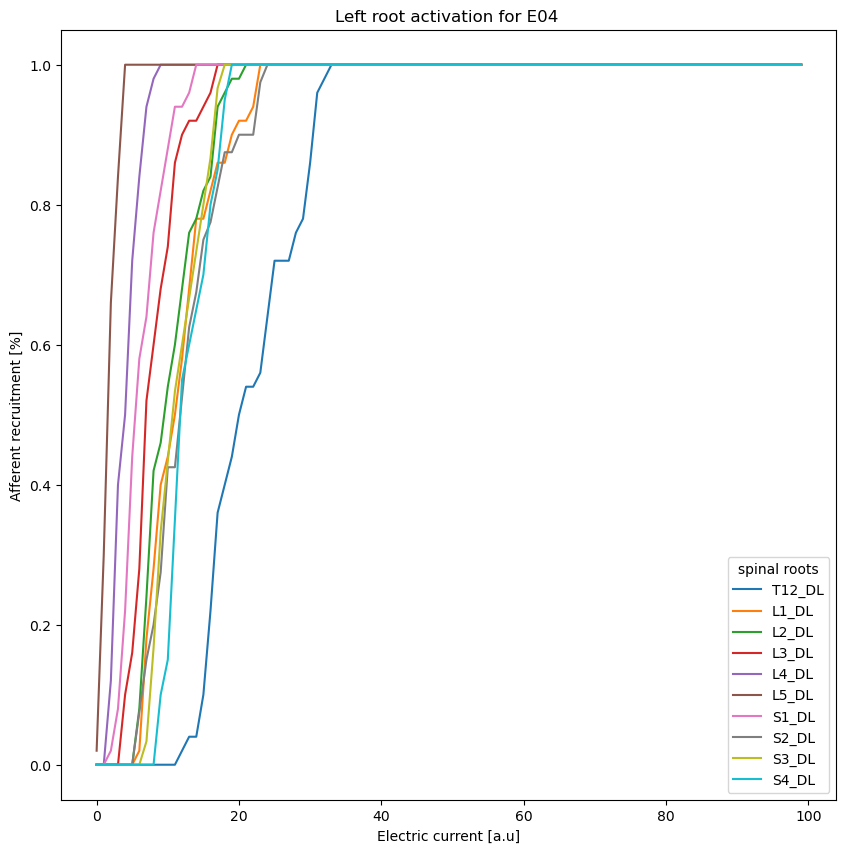

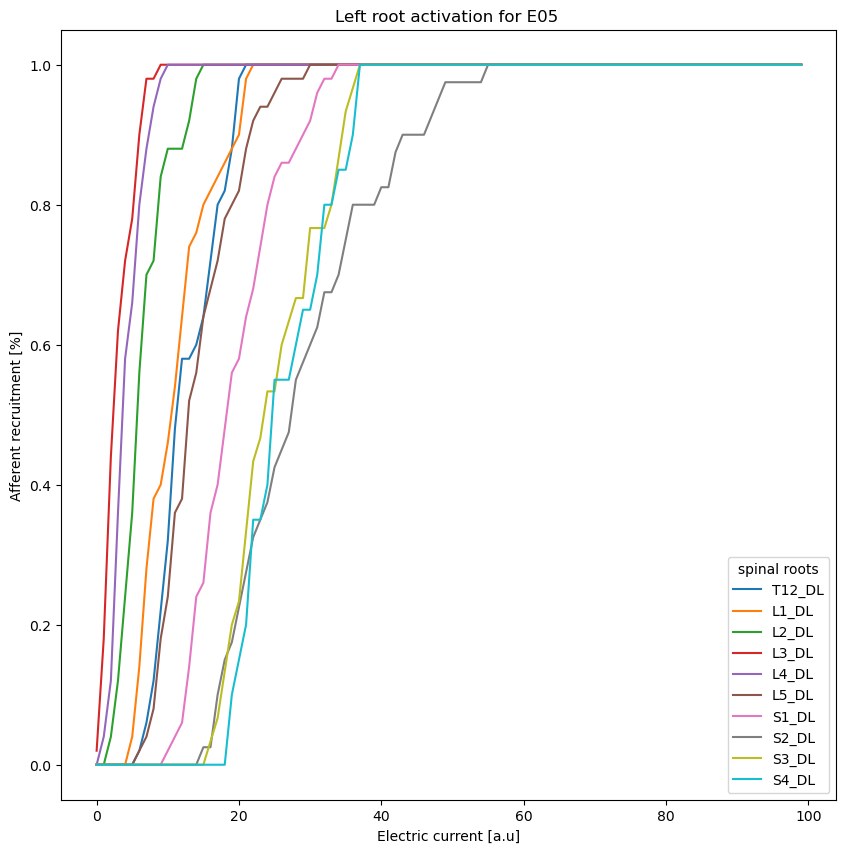

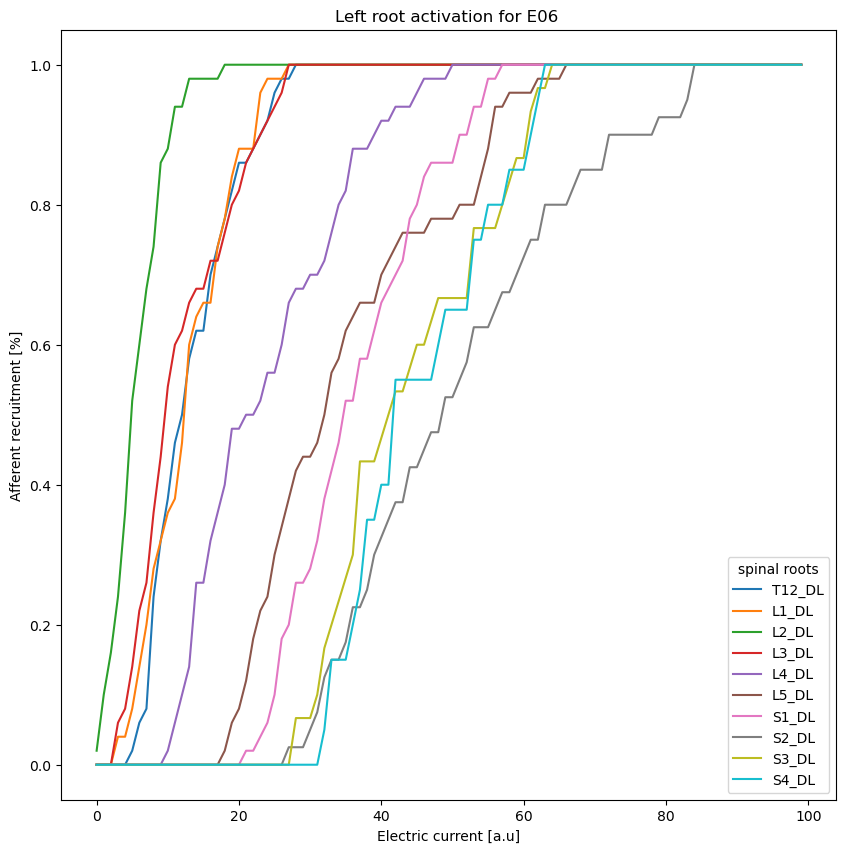

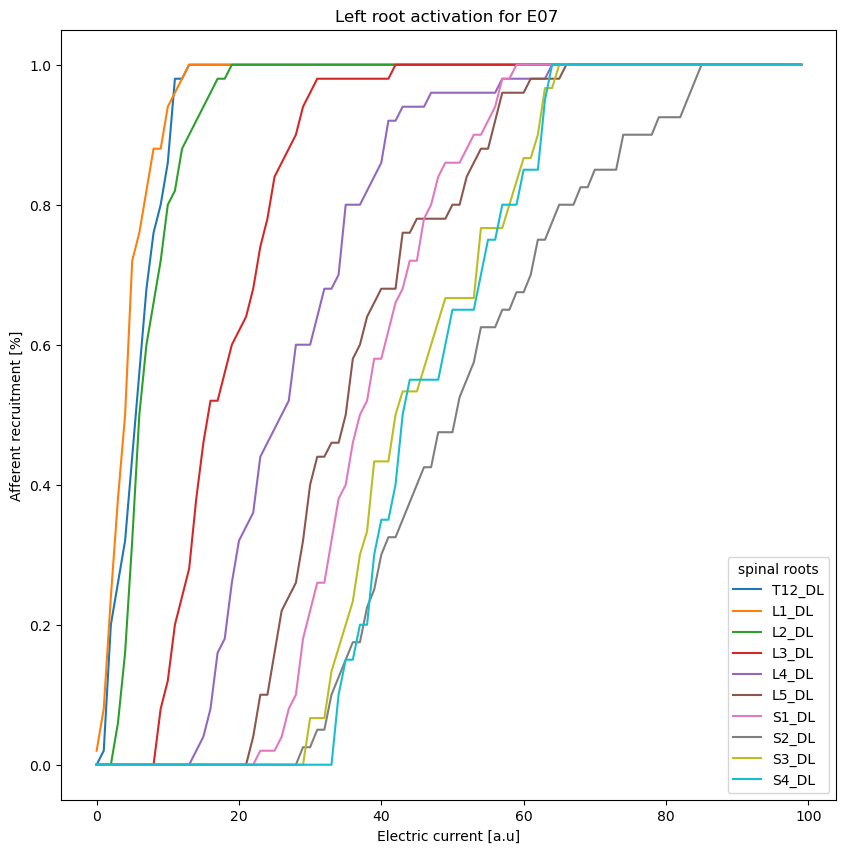

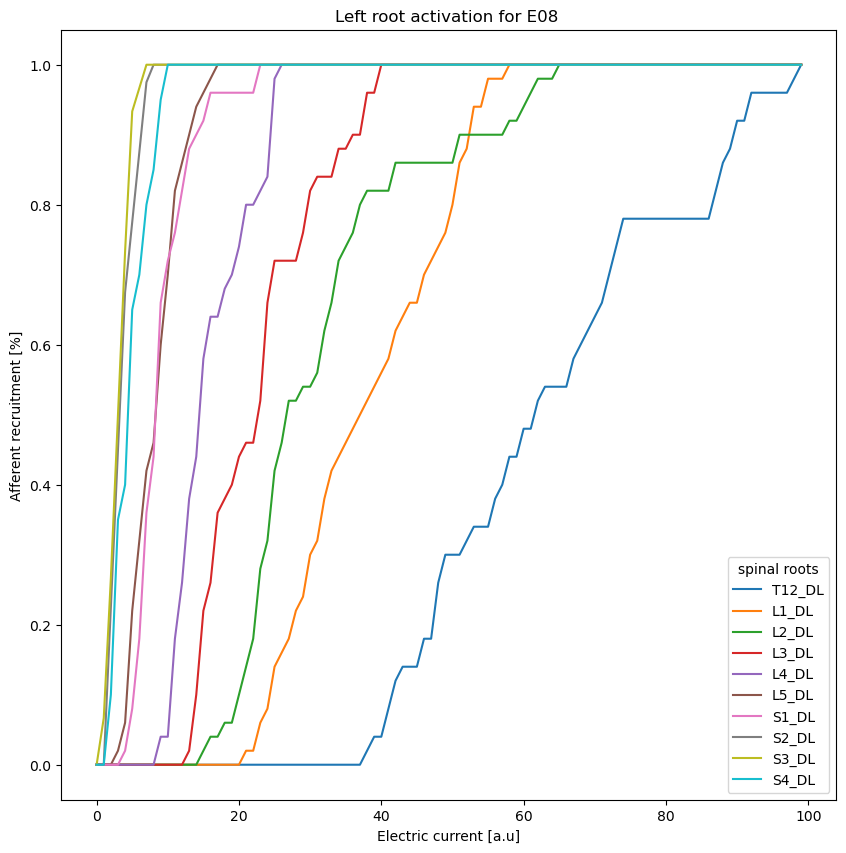

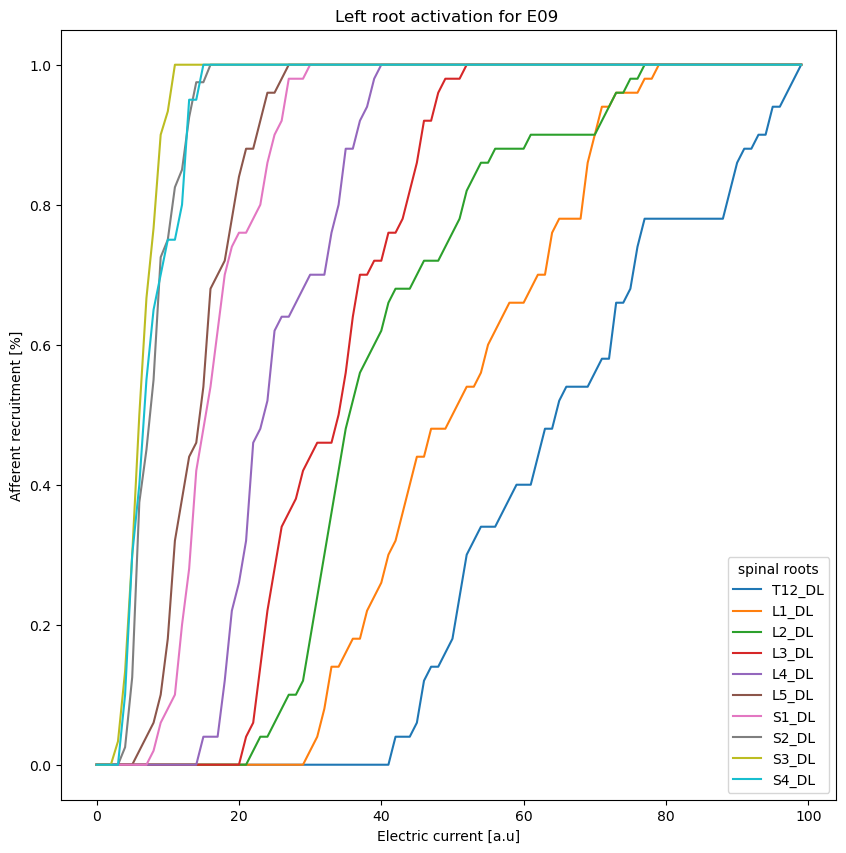

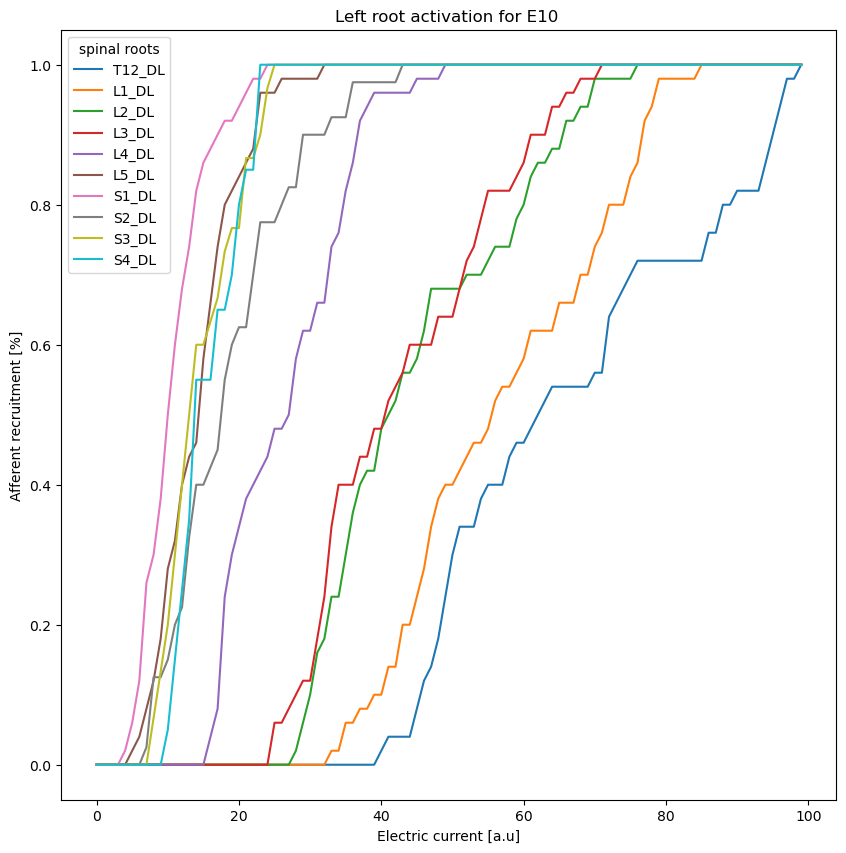

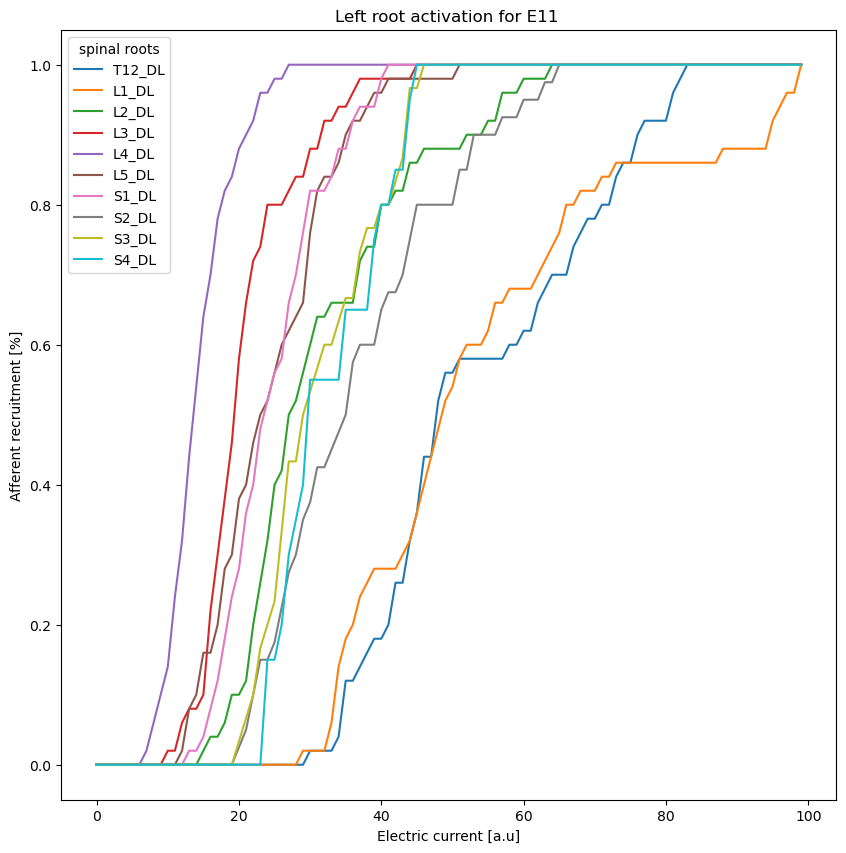

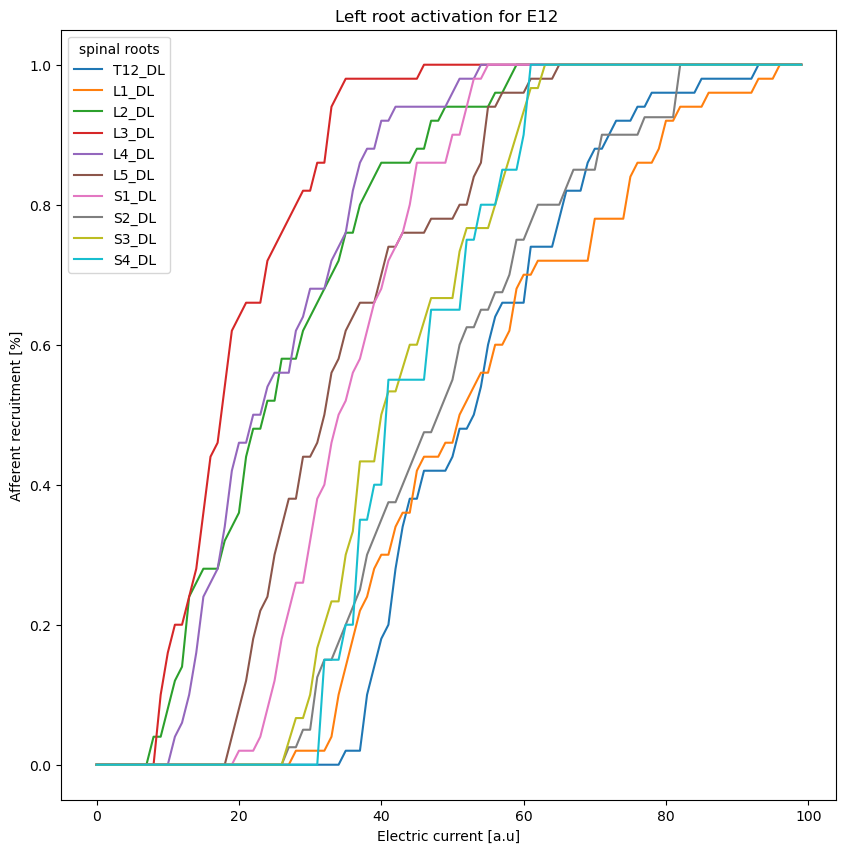

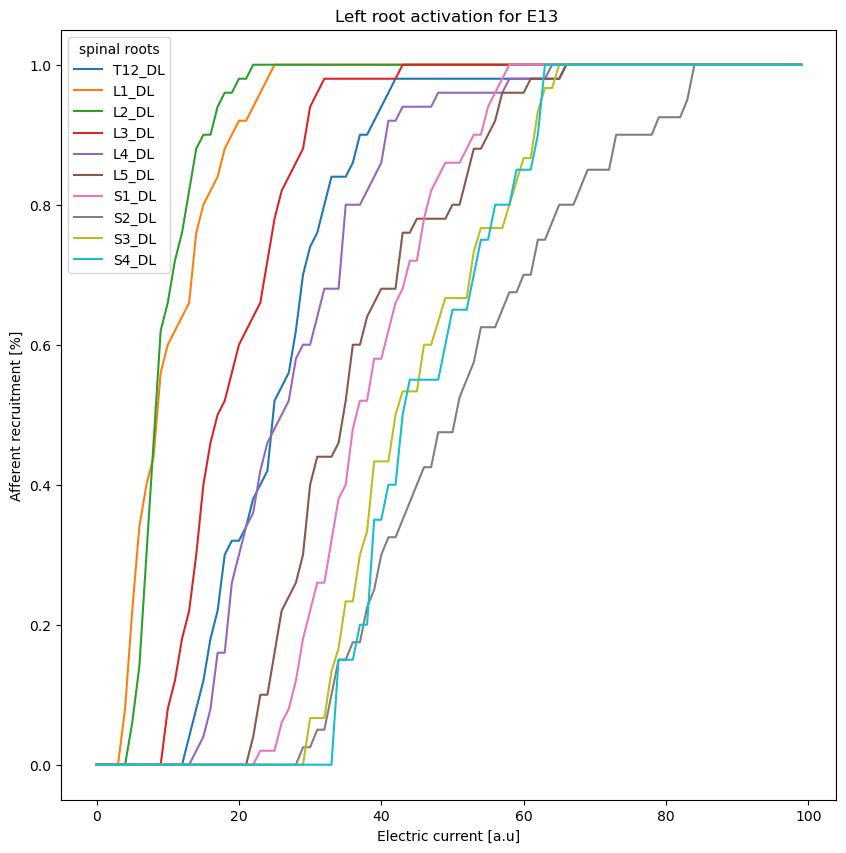

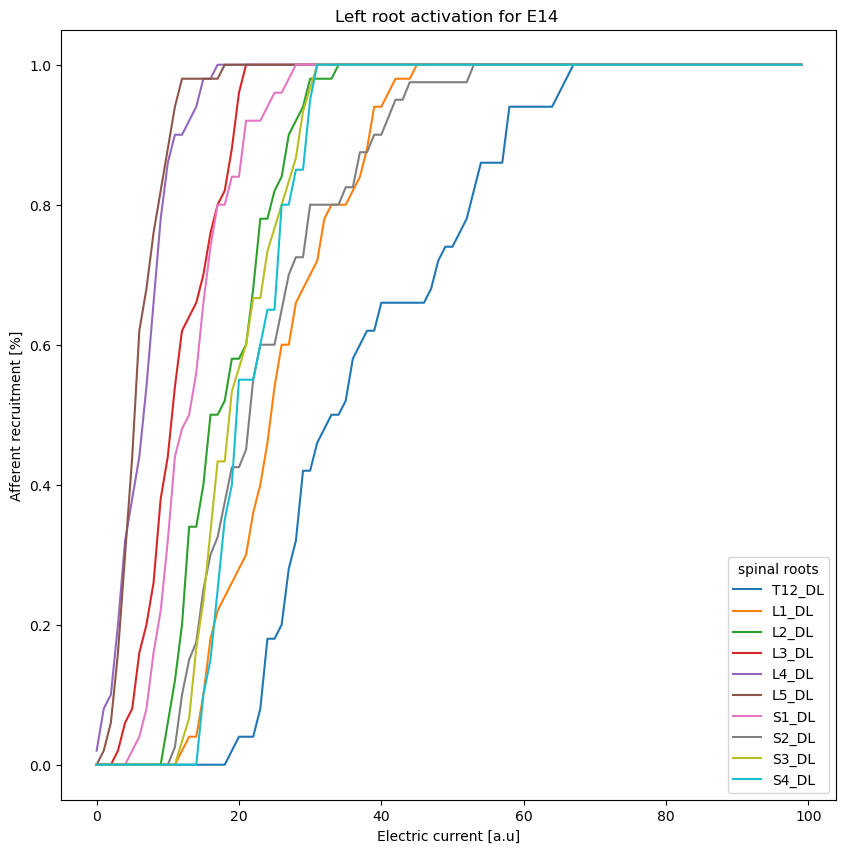

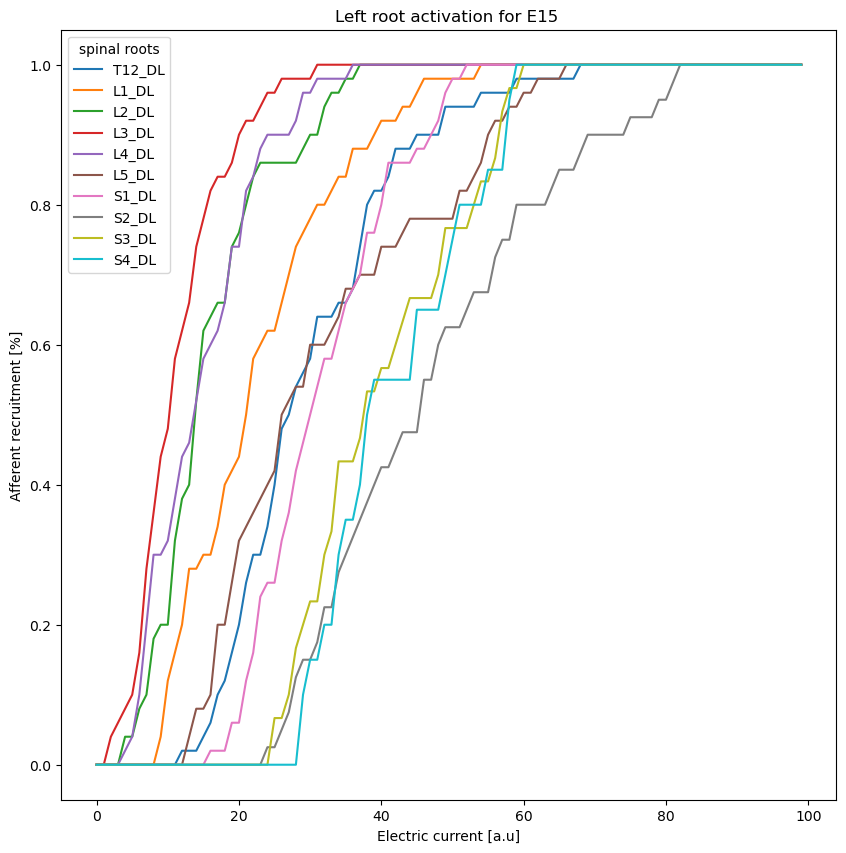

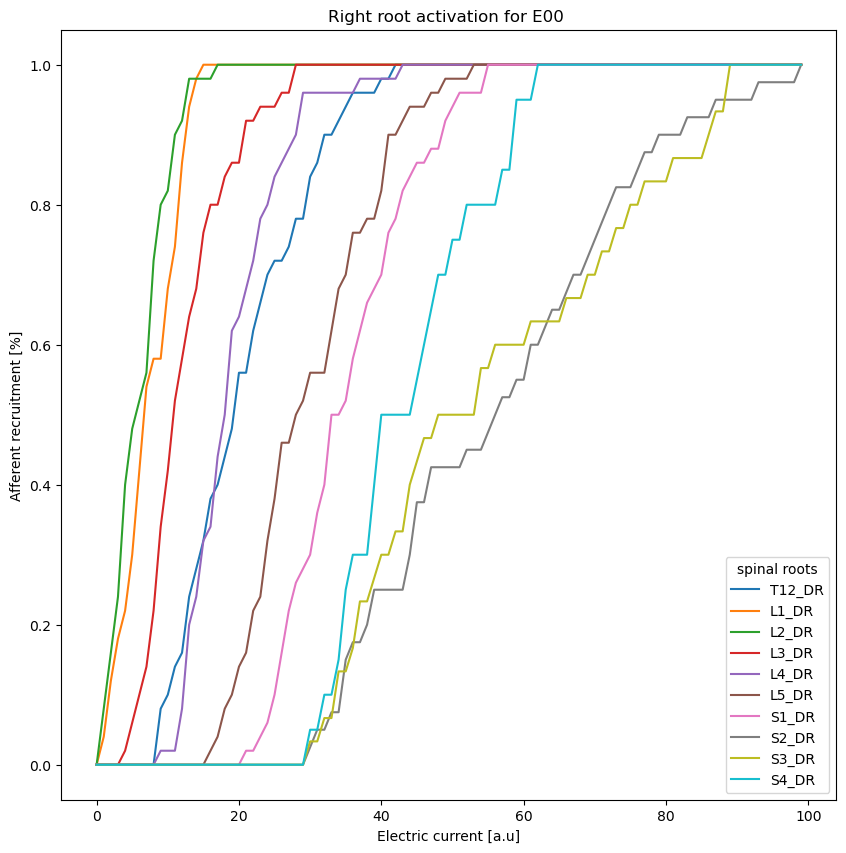

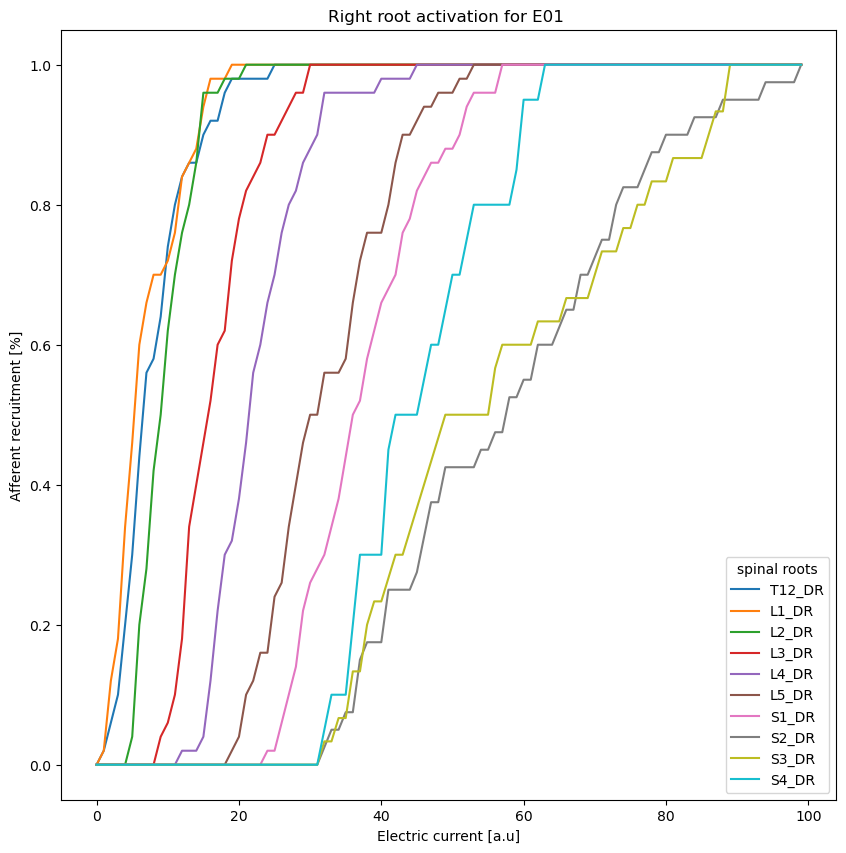

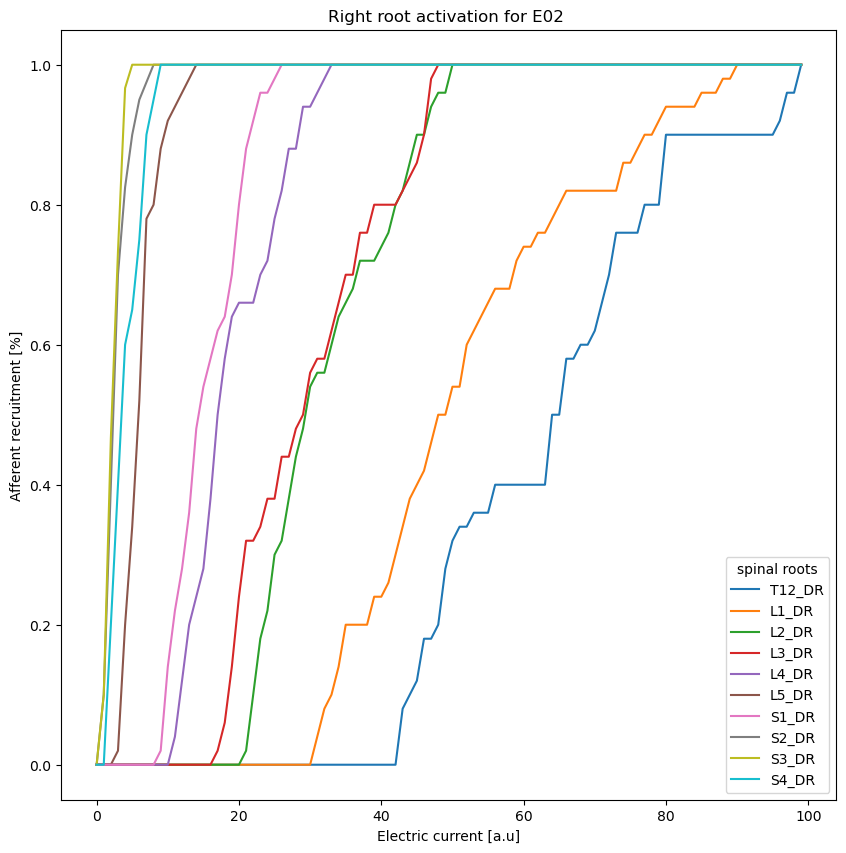

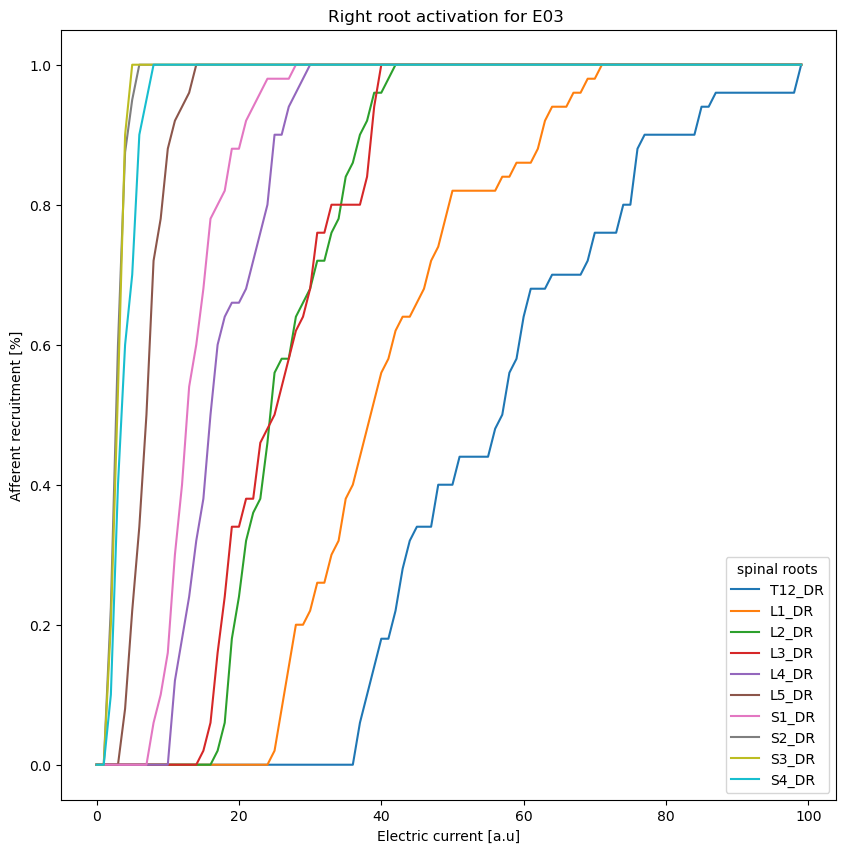

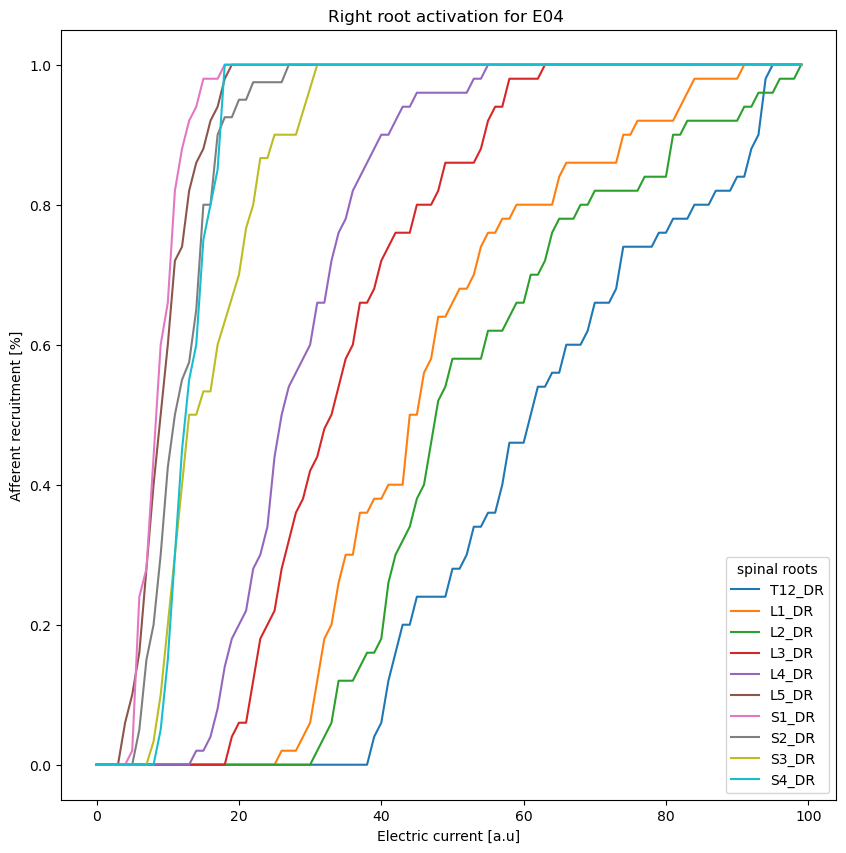

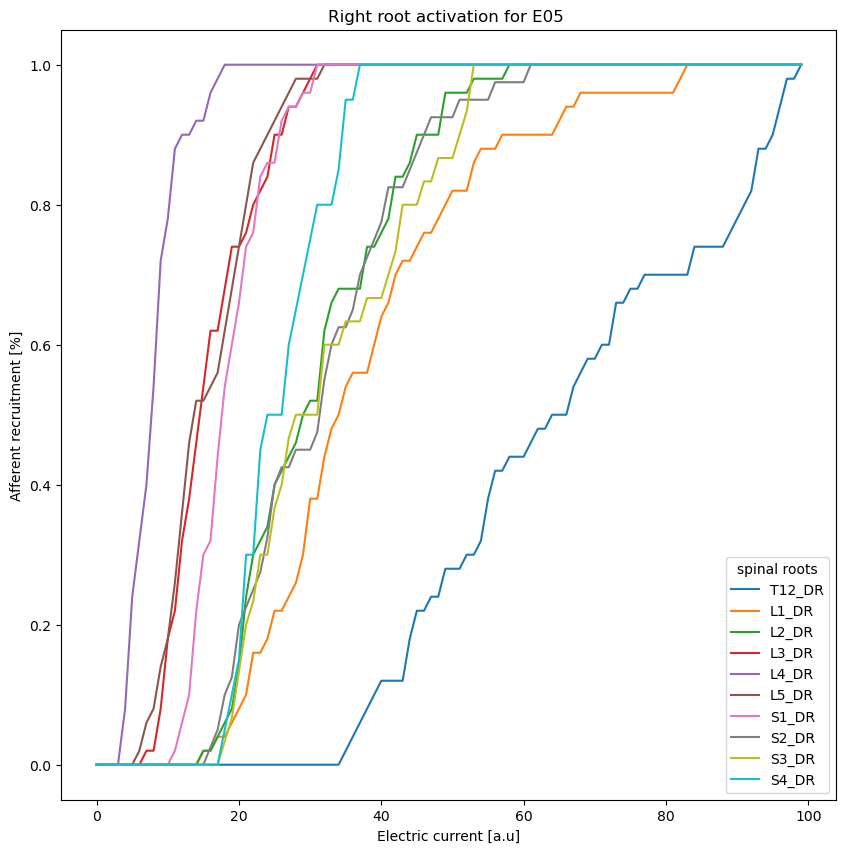

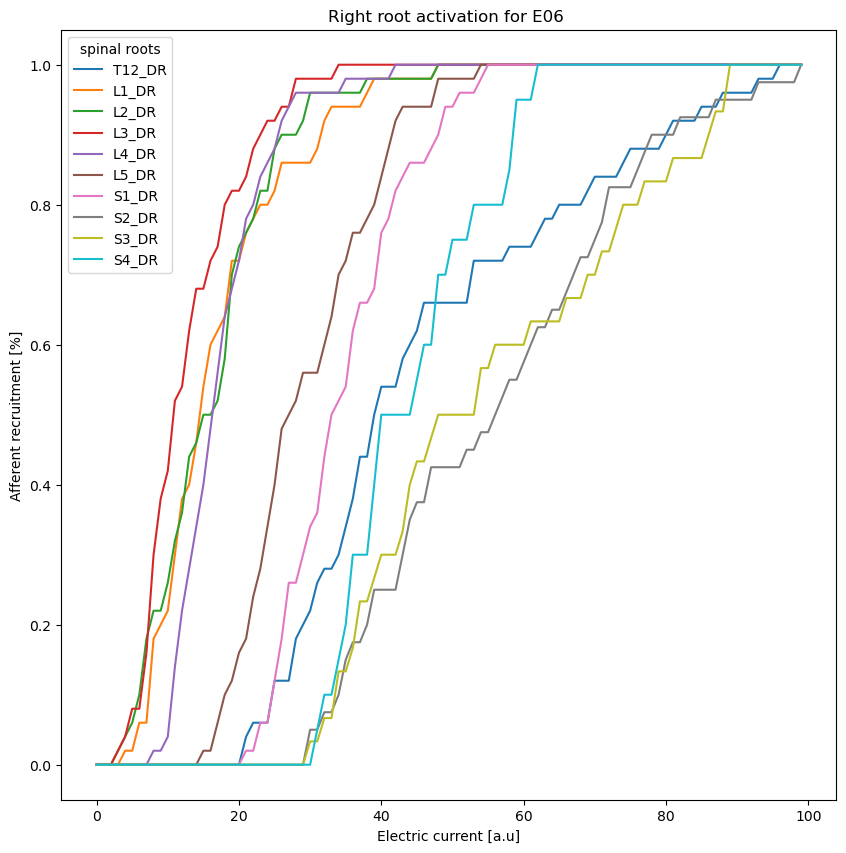

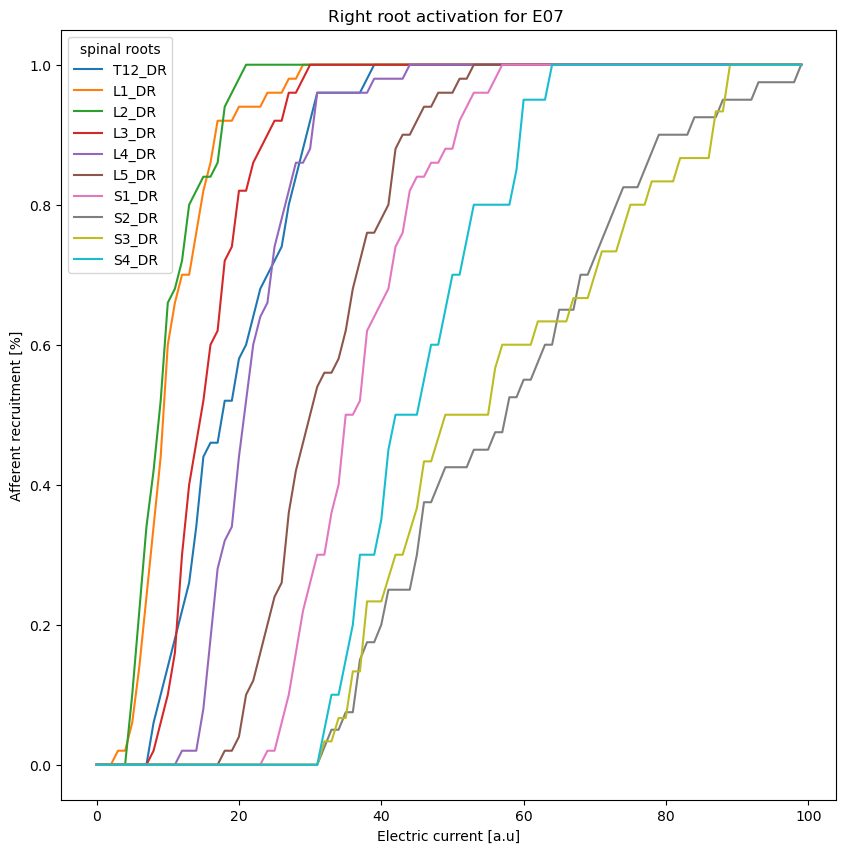

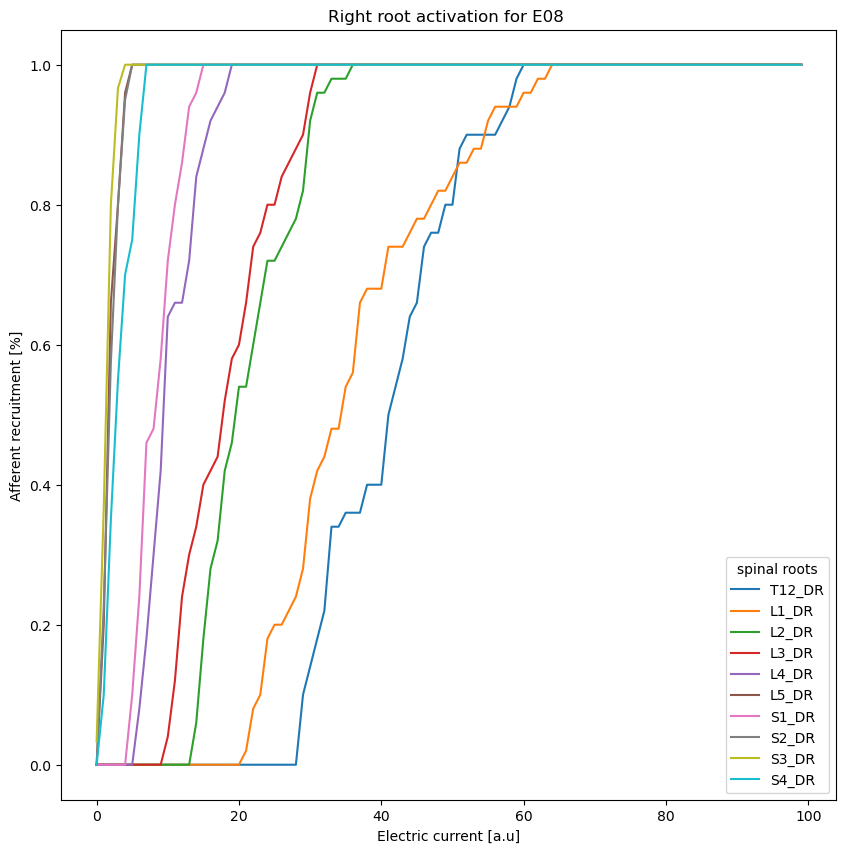

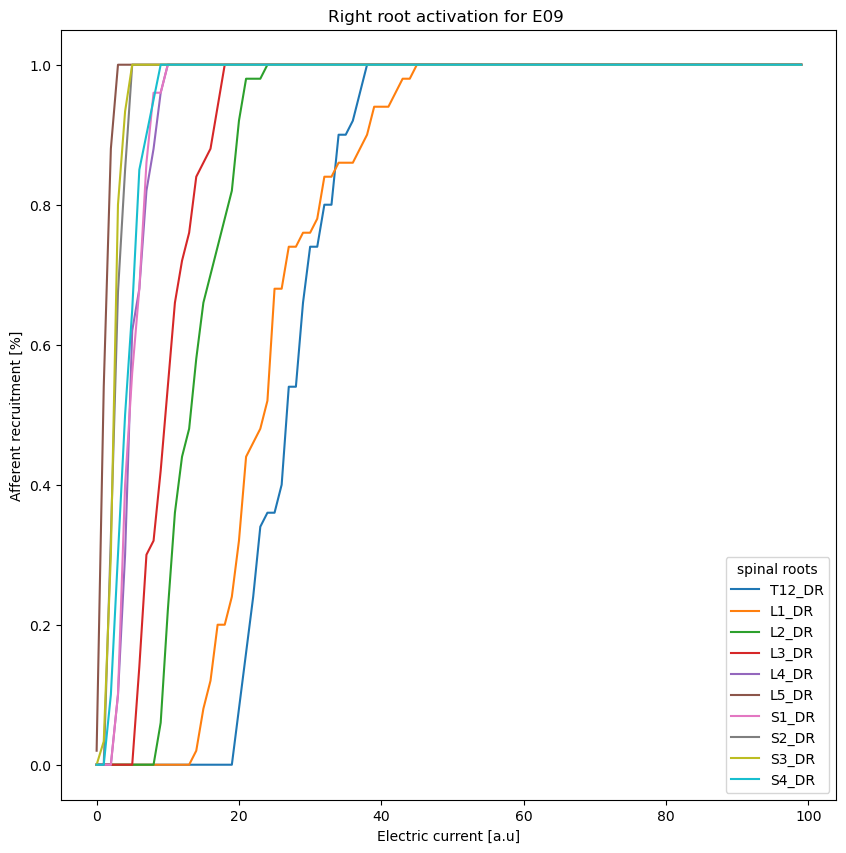

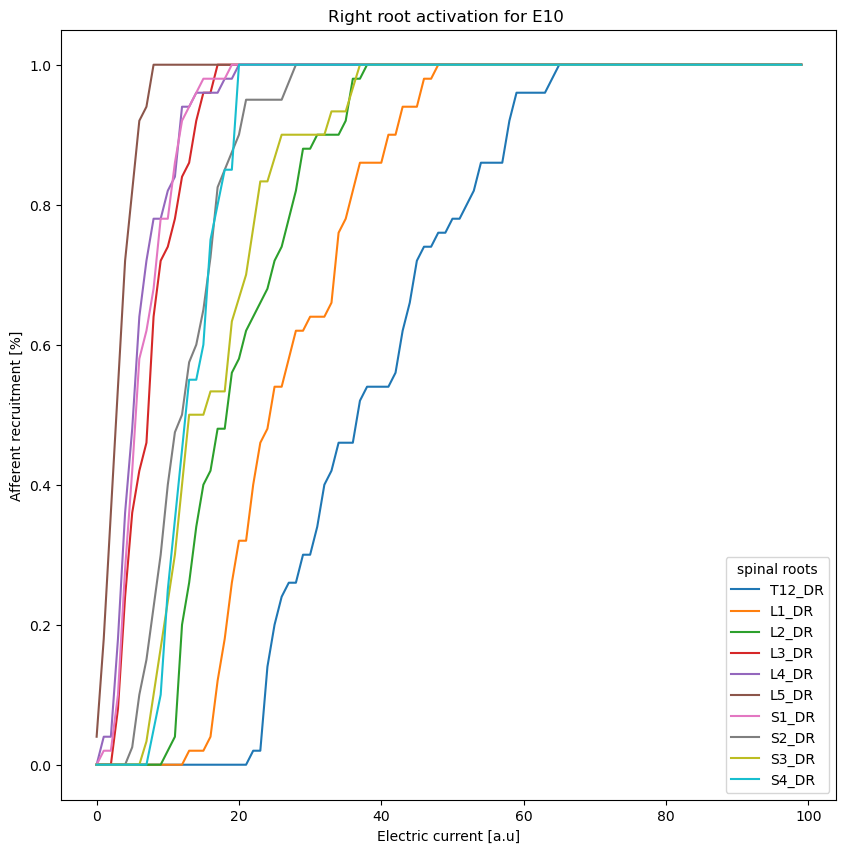

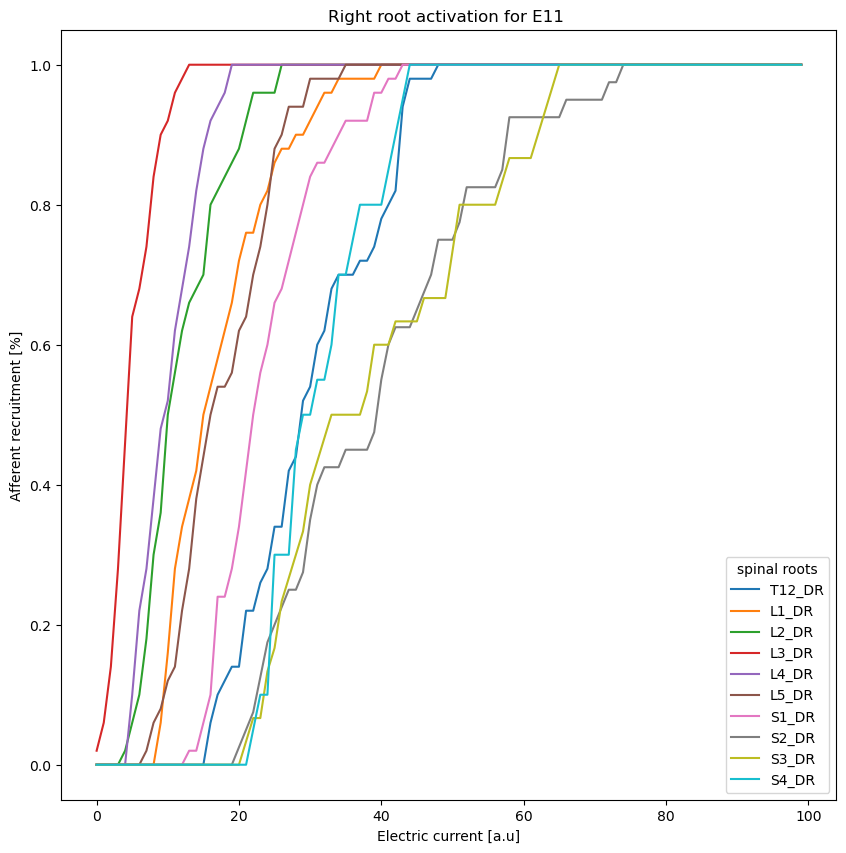

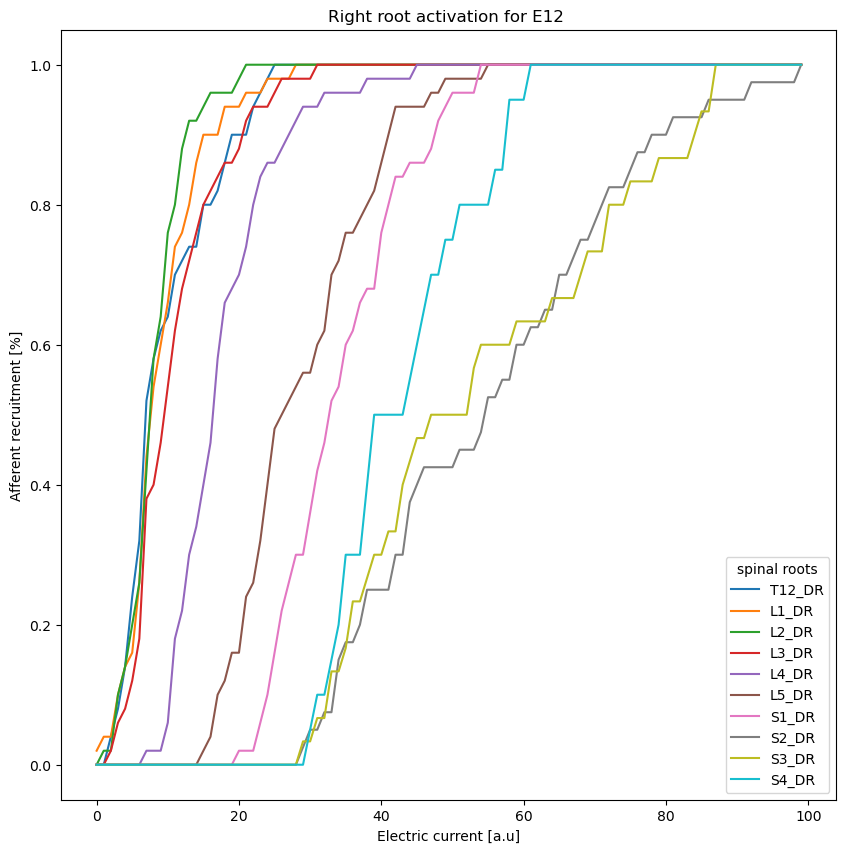

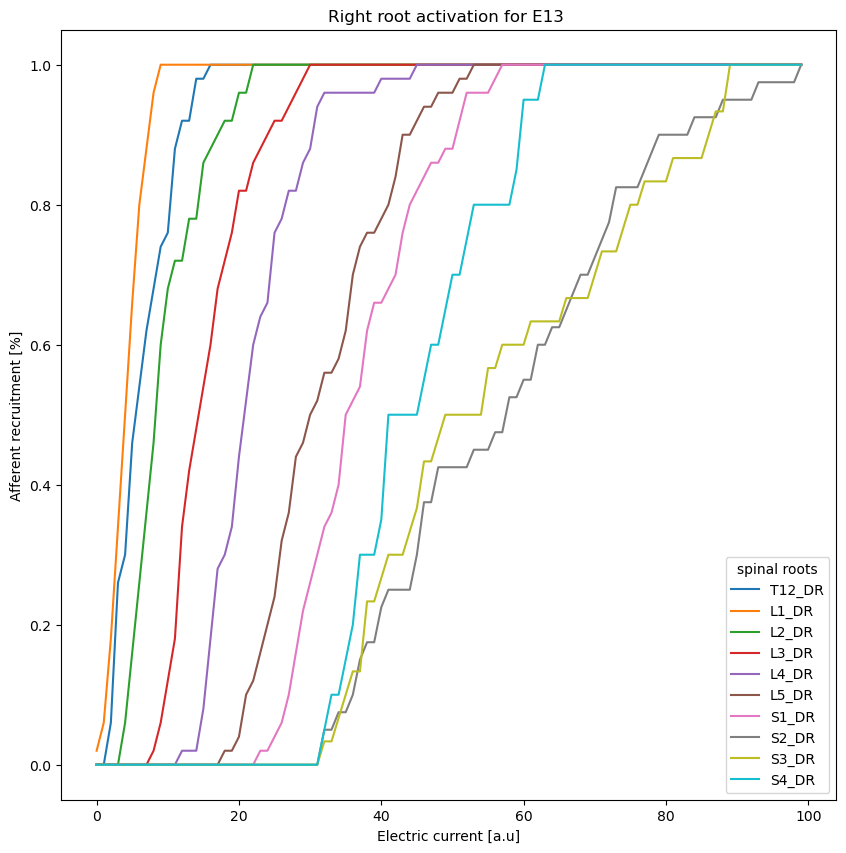

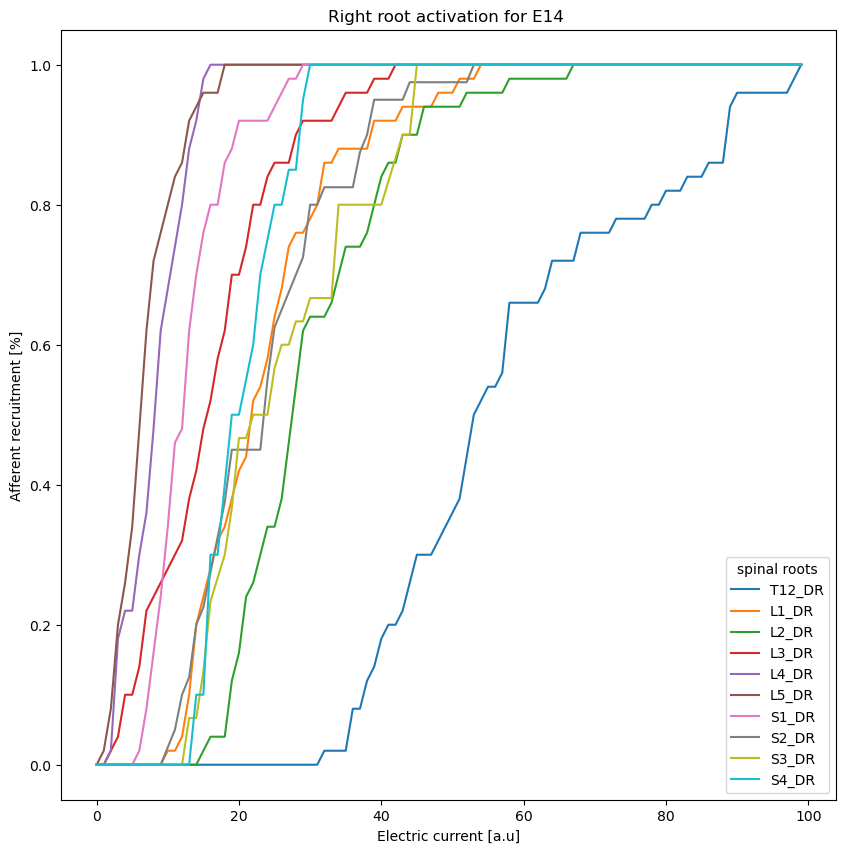

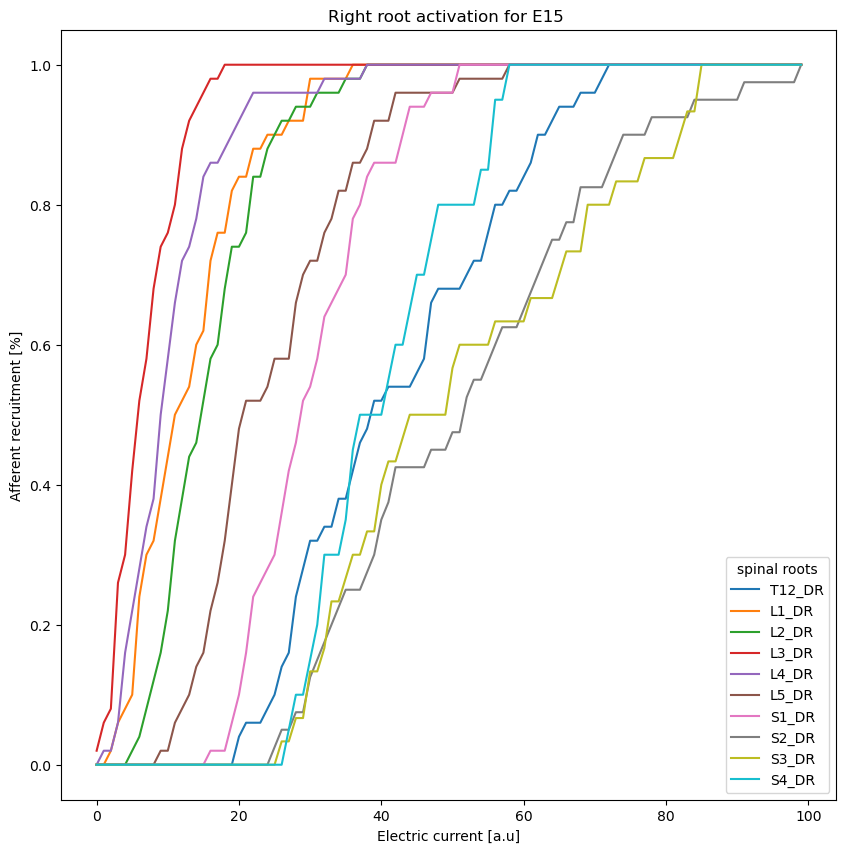

In [322]:
# save figure
save_fig=1
legend_title= "spinal roots"
xLabel="Electric current [a.u]"
yLabel="Afferent recruitment [%]"

x=np.arange(0, 100)
# Left activation
for electrode in range (len(electrodes_from_listing)):
    plt.figure(figsize=(10, 10))
    plt.title(f"Left root activation for {electrodes_from_listing[electrode]} ")
    for root in roots_left:
        
        plt.plot(x,recruitment_simulation[f"_{electrodes_from_listing[electrode]}_{root}"]["Recruitment"], label=root)
        plt.legend(title=legend_title)
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)

        if save_fig:
            data_file = electrodes_from_listing[electrode]+"_"+"recruitment_curve"+'.png'
            save_figure(folder_name="Recruitment_curve/roots", data_file=data_file)
           
    plt.show()

# Right activation
for electrode in range (len(electrodes_from_listing)):
    plt.figure(figsize=(10, 10))
    plt.title(f"Right root activation for {electrodes_from_listing[electrode]} ")
    for root in roots_right:
        
        plt.plot(x,recruitment_simulation[f"_{electrodes_from_listing[electrode]}_{root}"]["Recruitment"], label=root)
        plt.legend(title=legend_title)
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        if save_fig:
            data_file = electrodes_from_listing[electrode]+"_"+"recruitment_curve"+'.png'
            save_figure(folder_name="Recruitment_curve/roots", data_file=data_file)
    plt.show()

# Build Heat map

For now the computation of the number to make a heatmap electrodes/roots 
we do one approach by taking the  electric current at the point where afferent recruitment reaches 100%.



## Functions for the heatmap

In [135]:
# Get the number for the heatmap by extracting the electric current at the point where afferent recruitment reaches 100%

def get_number_for_heat_map_electric_current(electrode,root,recruitment_simulation=recruitment_simulation,electrodes_from_listing=electrodes_from_listing):
    """
    A function to get the number for the heatmap by by taking the  electric current at the point where afferent recruitment reaches 100%.

    Parameters
    ----------
    recruitment_simulation
        df, with recruitment for all electrode root combination
    electrodes_from_listing
        list, all electrodes

    """
    # extract first index where recruitment =1.0
    electric_current=recruitment_simulation[f"_{electrodes_from_listing[electrode]}_{root}"]["Recruitment"][np.where(1==recruitment_simulation[f"_{electrodes_from_listing[electrode]}_{root}"]["Recruitment"])[0]].index[0]

    return electric_current



In [117]:
### Interpolate unknown values in the heat map ###

def interpolate_missing_pixels(image, mask, method, fill_value=0):

    """
    A function to interpolate missing values.
    
    Parameters
    ----------
    image 
        2D np.array
    mask
        a 2D boolean array, True indicates missing values
    method
        interpolation method, one of 'nearest', 'linear', 'cubic'.
    fill_value
        which value to use for filling up data outside the
        convex hull of known pixel values.
        Default is 0, Has no effect for 'nearest'.
        
    Return
    ----------
    interp_image
        nd.array with missing values interpolated
    """

    h, w = image.shape[:2]
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))

    known_x = xx[~mask]
    known_y = yy[~mask]
    known_v = image[~mask]
    missing_x = xx[mask]
    missing_y = yy[mask]

    interp_values = interpolate.griddata(
        (known_x, known_y), known_v, (missing_x, missing_y),
        method=method, fill_value=fill_value
    )

    interp_image = image.copy()
    interp_image[missing_y, missing_x] = interp_values

    return interp_image


In [118]:
### text to define electrodes in plot
text = np.array([
['', '','', '','', '', '', '', ''], ['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','1', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '7','', '','', '', '', '13', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','0', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '6','', '','', '', '', '12', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','15', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''], ['', '5','', '','', '', '', '11', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','14', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '4','', '','', '', '', '10', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''], ['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '3','', '2','', '8', '', '9', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', '']])

## Plot the heatmap

In [312]:
## Plot heat map with interpolated data ##
def get_heat_map_individual_msc_with_interpolation(data=recruitment_simulation, save_fig=0,folder_name=0,  data_structure=0, interpol_method='cubic', text=text, electrodes_from_listing=electrodes_from_listing):
    """
    A function to create a heatmap where datapoints inbetween the given data are interpolated.
    -Interpolation method can be adapted 'nearest', 'linear', 'cubic', by changing the interpolation function
    -numbers fed to the heatmap can be adapted by changing the 'get_number_for_heatmap' function

    Parameters
    ----------
    data
        data used for the heatmap
    folder_name
        which folder is it saved to?
        eg. rectruitment_curve/roots
        default=0
    name_img
        name of image,
        eg. electrodes_from_listing[electrode]+"_"+"recruitment_curve" 
        default=0
    data_structure
        str, type of normalisation used
        only used when it should be specifically mentioned, 
        defualt=0
    interpol_method
        interpolation method, one of 'nearest', 'linear', 'cubic'
    text
        array used for annotation; to define electrodes in the plot
    electrodes_from_listing
        list with all electrodes used

    """
  

    ## Build tensor filled with -1, thus undefined values are easily recognisable ##
    paddle_lead =np.zeros(80* 9)
    paddle_lead=np.array([-1]*len(paddle_lead))
    paddle_lead=paddle_lead.reshape((80,9))

    ## Get the lead image as an array so we can plot it ##
    map_img = mpimg.imread('/Users/nealarohner/Desktop/Projectome_Finder/code/Refrences/lead_original.png') 



    ## For every muscle fill tensor with values ##
    # for muscle_i in range(len(mt_muscles[0:2])):
    for root in roots:
    # for root in ['S4_DR']:
        
        # Set settings for plot ## 
        fig, ax = plt.subplots(figsize=(3,10))# creating subplot
        ax.set_title(f"{interpol_method} interpolated heat map for root {root}", size=18, fontstyle='italic', pad=20)# set title

        # Define electrode placements
        numbers=[1, 0, 15, 14]
        for index, number in enumerate(numbers, start=0): 
            n=(14*index)+3 # equal spacing
            row=4
            e=number
            #save the same value for all the pixels in the electrode
            for i in range(6):
                # Save root value for an electrode
                paddle_lead[i+n][row] =get_number_for_heat_map_electric_current(electrode=e,root=root)
        

        numbers=[7, 6, 5, 4]
        for index, number in enumerate(numbers, start=0):  
            n=(14*index)+10 # equal spacing
            row=1
            e=number
            #save values to the indeces
            for i in range(6):
                    paddle_lead[i+n][row] =get_number_for_heat_map_electric_current(electrode=e,root=root)

        numbers=[13, 12, 11, 10]
        for index, number in enumerate(numbers, start=0):   
            n=(14*index)+10 # equal spacing
            row=7
            e=number
            #save values to the indeces
            for i in range(6):
                    paddle_lead[i+n][row] =get_number_for_heat_map_electric_current(electrode=e,root=root)

        numbers=[3, 2, 8, 9]
        for index, number in enumerate(numbers, start=0):  
            n=55+10
            row=1+(index*2)
            e=number
            #save values to the indeces
            for i in range(6):
                    paddle_lead[i+n][row] =get_number_for_heat_map_electric_current(electrode=e,root=root)

        # Create boolean, with true for the unknown values
        mask=paddle_lead<0 # all unknown values were set to -1,to recognise datapoints for interpolation 

        ## Get interpolation for the unknown values ##
        interpolated_image=interpolate_missing_pixels(
        image=paddle_lead,
        mask=mask,
        method=interpol_method,
        fill_value= 100 # max value is 100 and here high values mean low activation
        )

        ## Set values outside of lead to 100 (since here opposite activation the smaller the more activation) ##
        # do it after interpolation that this doent get taken into account for interpolation
        nr_columns=[8, 4, 2, 1, 1, 1, 2, 4, 8]
        for index, columns in enumerate(nr_columns):
            for col in range(0, columns):
                    interpolated_image[col][0+index] = 100 # max value is 100 and here high values mean low activation

        nr_columns=[7, 5,4, 4, 4, 4,4, 5, 7]
        for index, columns in enumerate(nr_columns):
            for col in range(79, 79-columns, -1):
                    interpolated_image[col][0+index] = 100 # max value is 100 and here high values mean low activation


        ## Drawing heatmap on current axes ##
        hmax= sns.heatmap(data=interpolated_image, 
            annot=text,
            # annot=True,
            fmt="",
            cmap=LinearSegmentedColormap.from_list('', ['r', 'white']),
            cbar_kws={'label': "Electric current [a.u] at 100'%' afferet recrutiment"},
            yticklabels=False, xticklabels=False, 
            vmin=100, vmax= 0, 
            alpha = 0.75, # whole heatmap is translucent
            zorder = 2,
                )
        hmax.imshow(map_img,
            aspect = hmax.get_aspect(),
            extent =hmax.get_xlim() + hmax.get_ylim(),
            zorder = 1) #put the image under the heatmap

        ## Define Textbox 
        if data_structure:
            # needed if we want to point out data structure
            axbox = fig.add_axes([-0.5, 1.0, 1., 0.05]) #[left, bottom, width, height]
            text_box = TextBox(axbox,label=None, textalignment="center")
            text_box.set_val(f"Normalisation method: {data_structure}")  # Trigger `submit` with the initial string.

      
        ## Save plots 
        if save_fig:
            data_file = root+"_"+"heat_map"+"_interpolation"+'.png'
            save_figure(folder_name, data_file)
        show() 

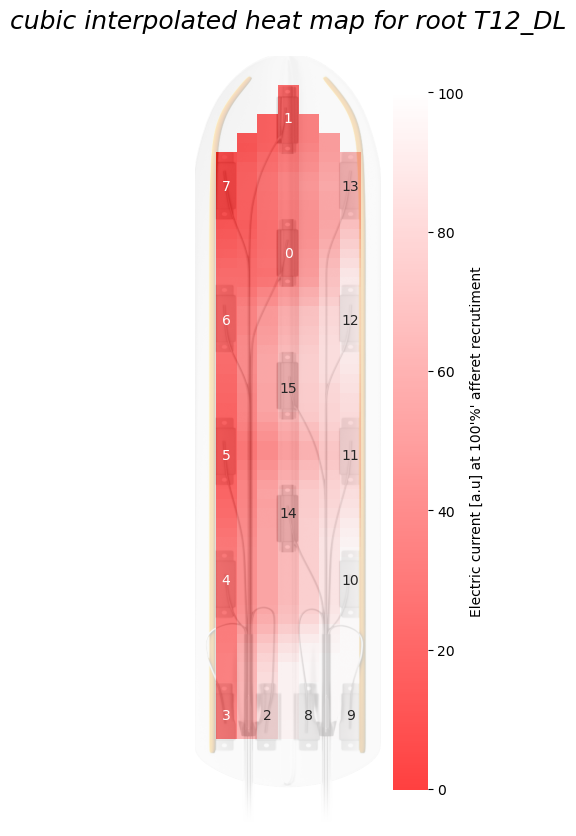

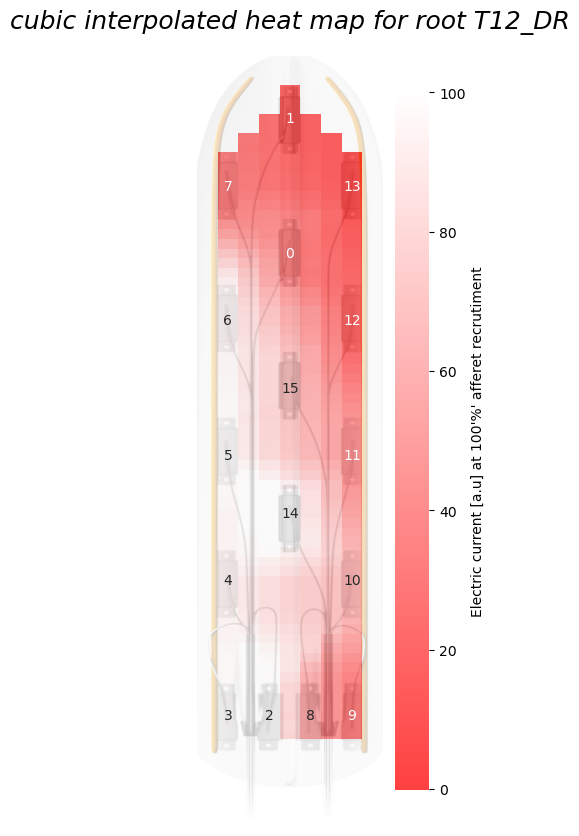

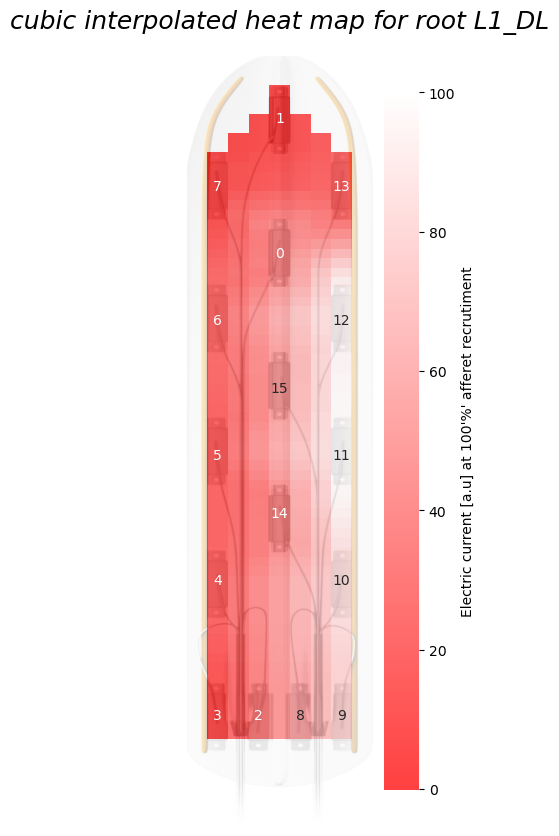

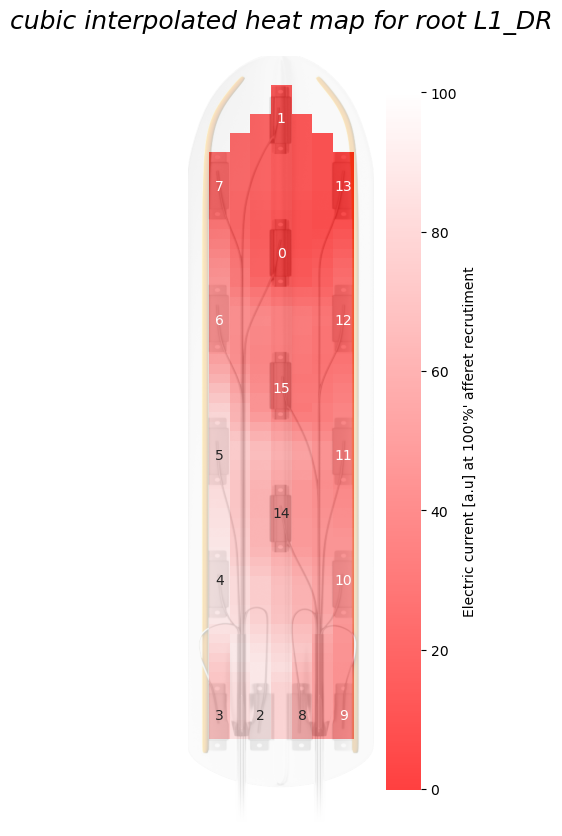

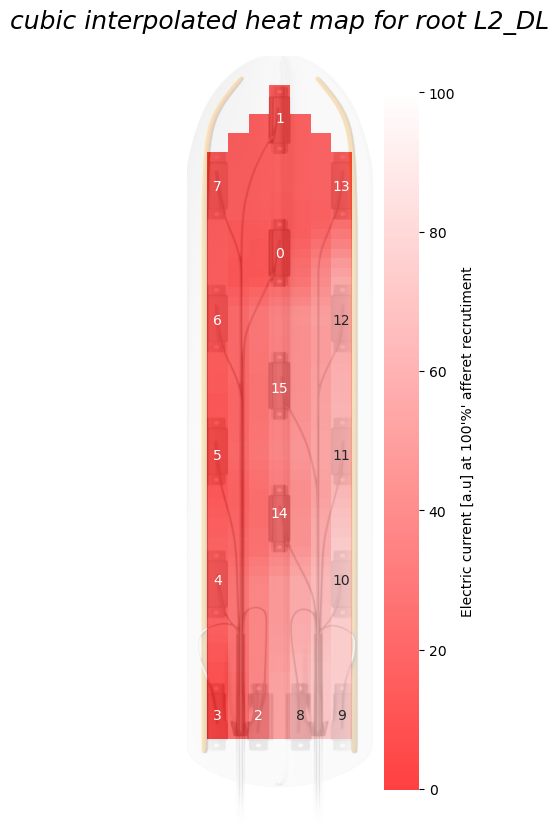

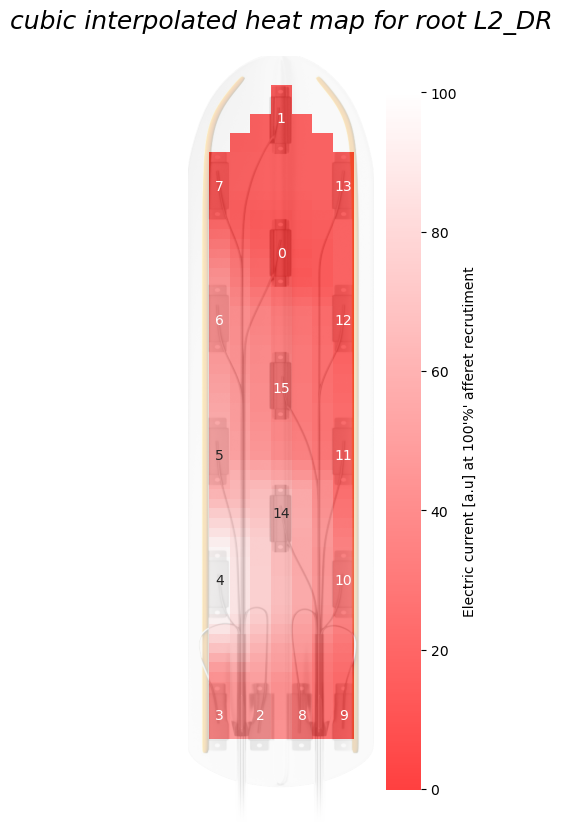

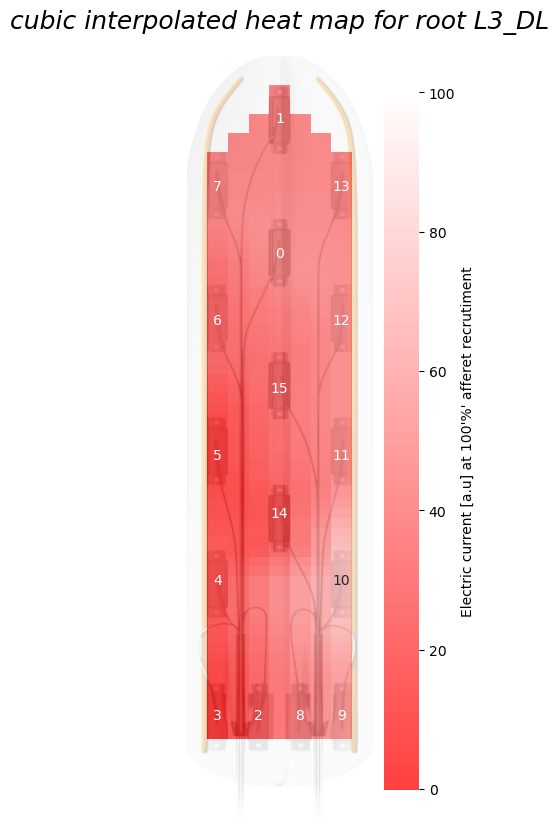

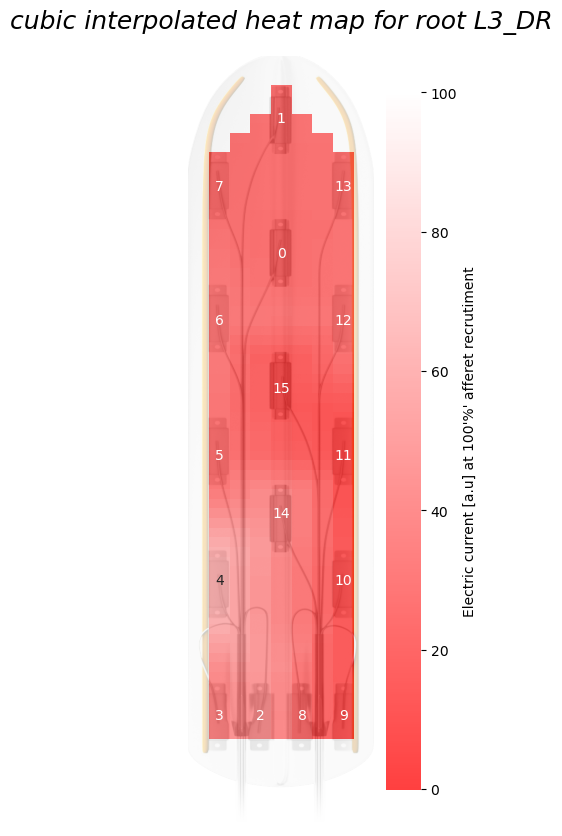

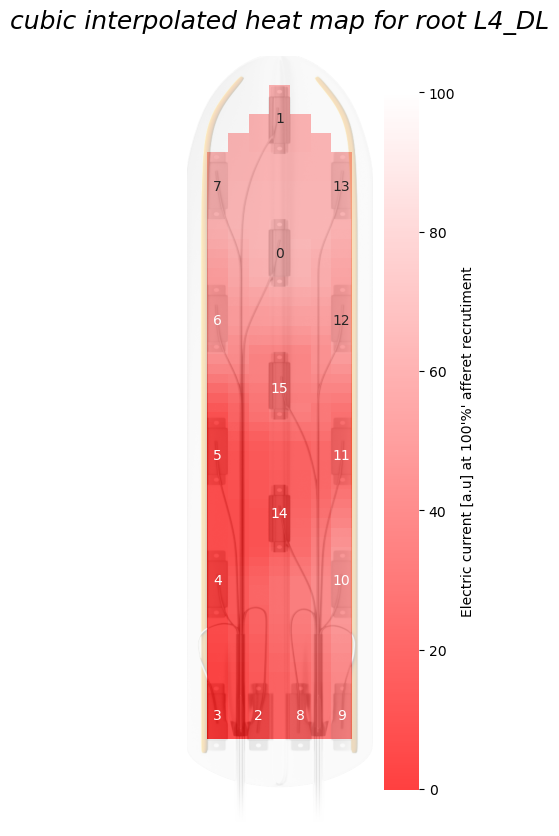

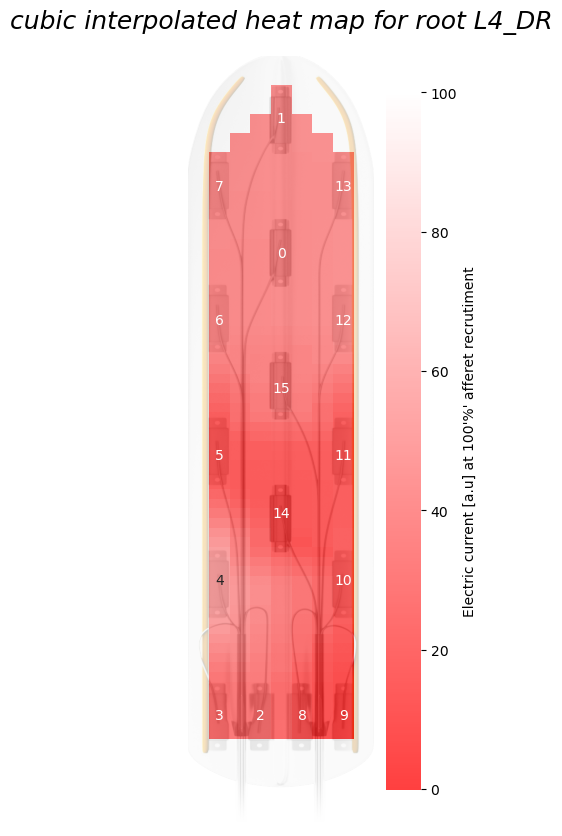

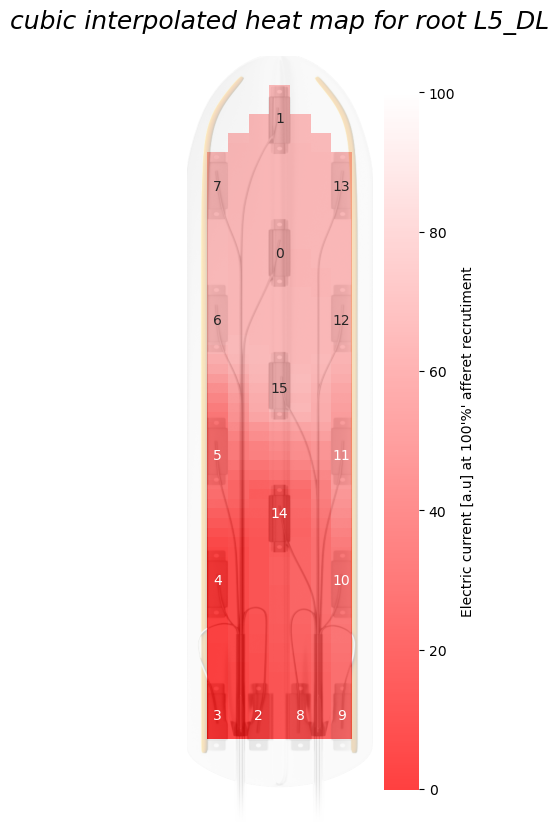

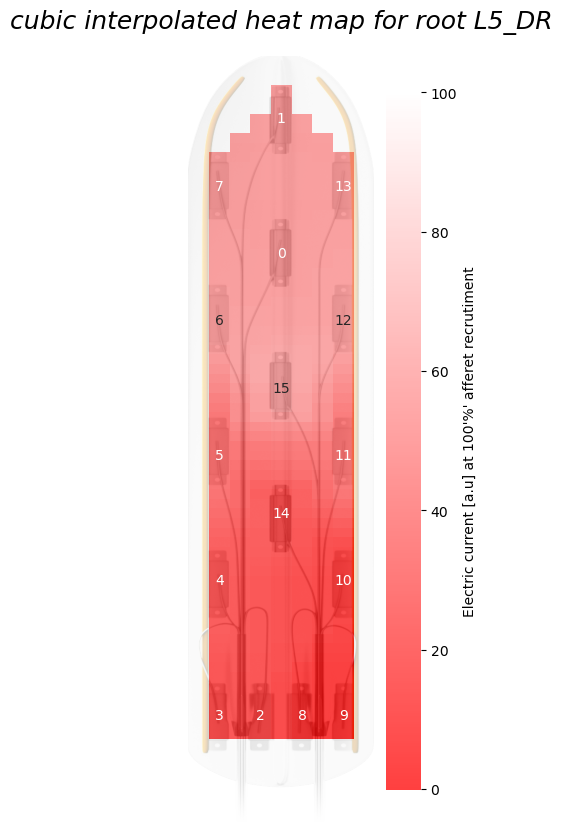

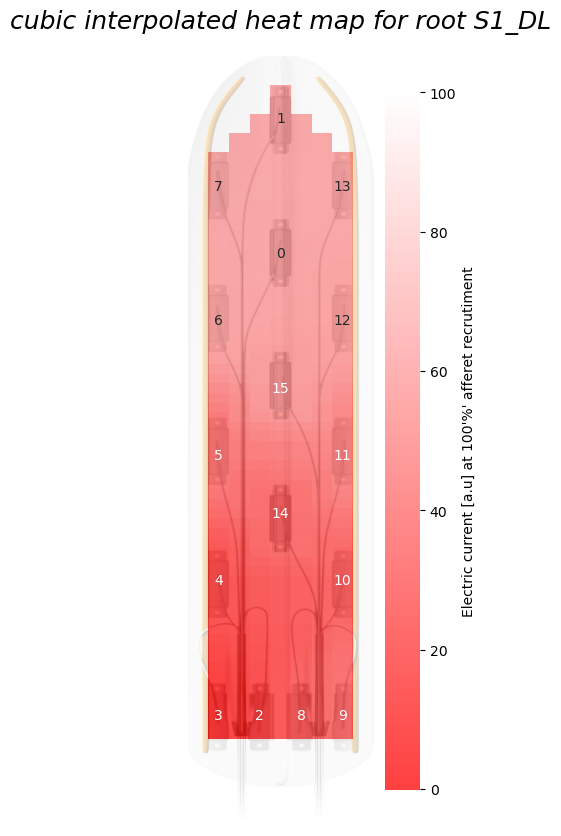

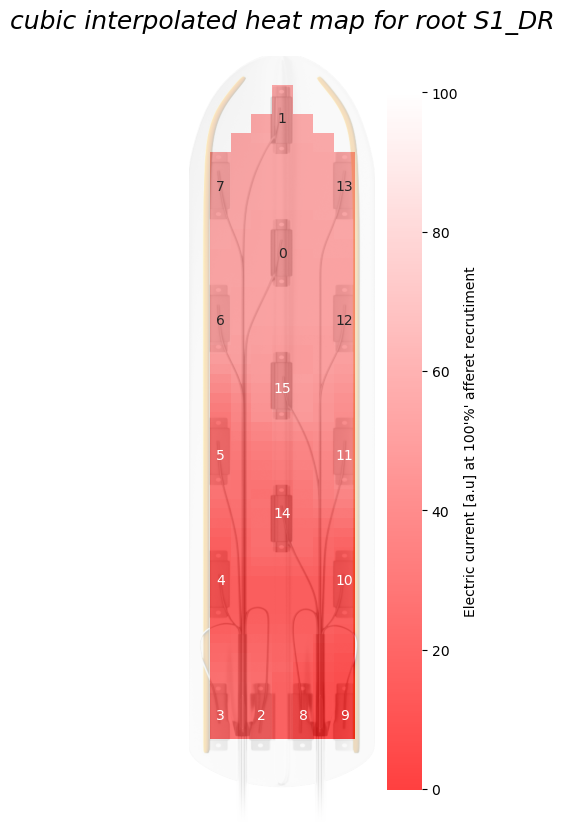

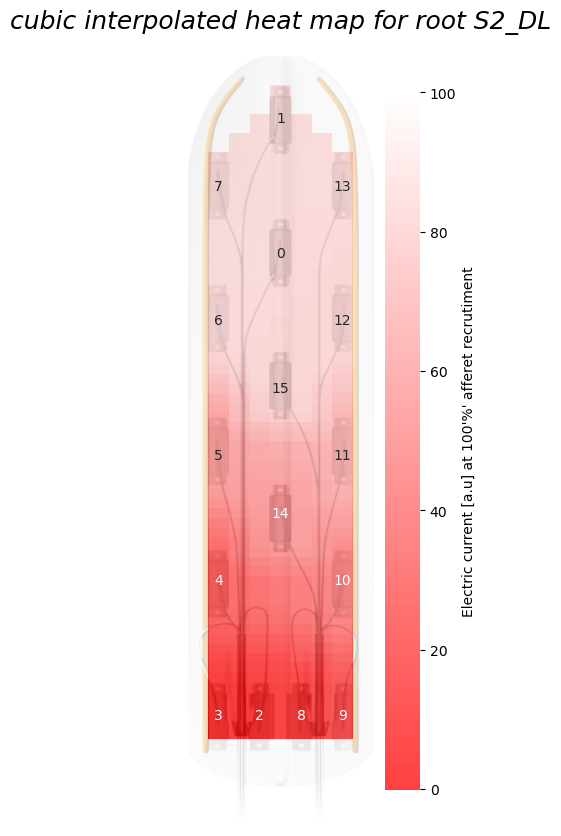

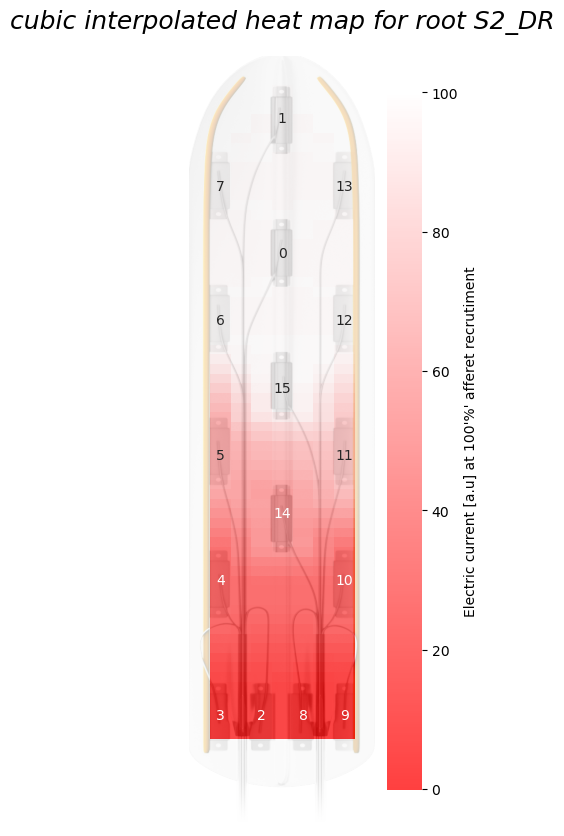

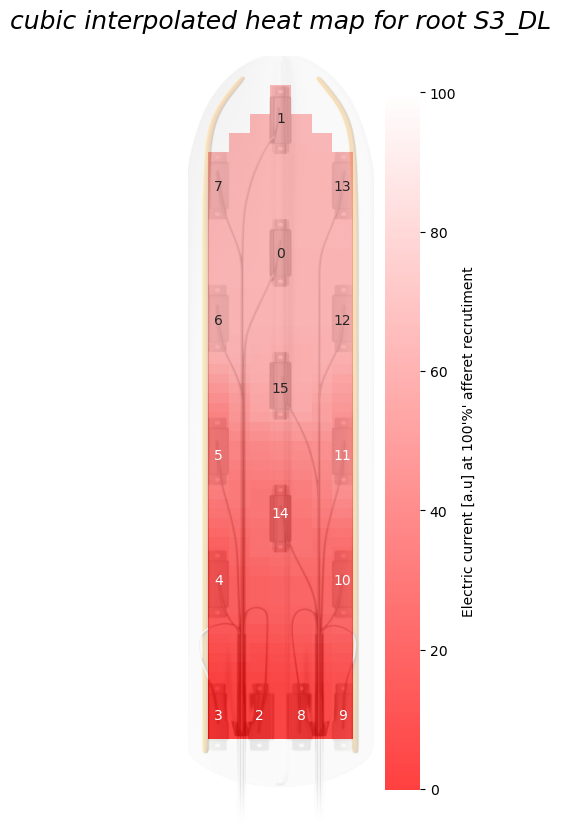

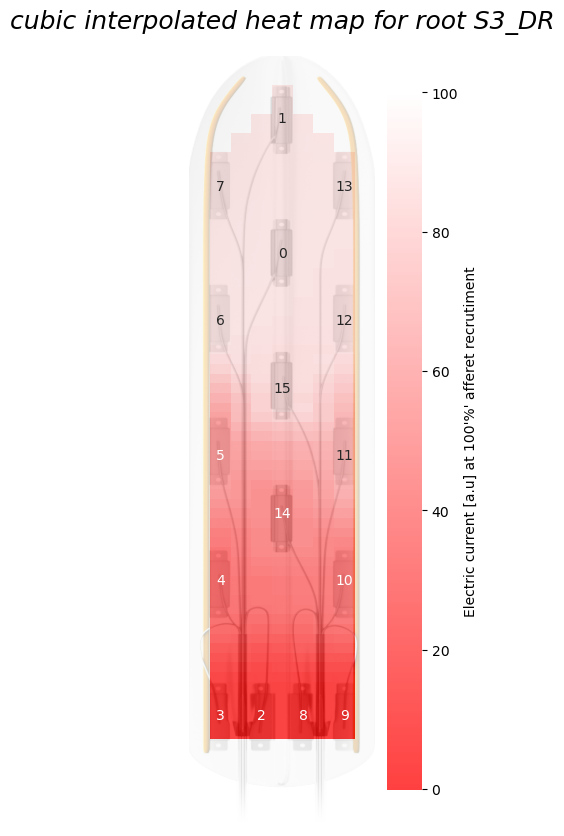

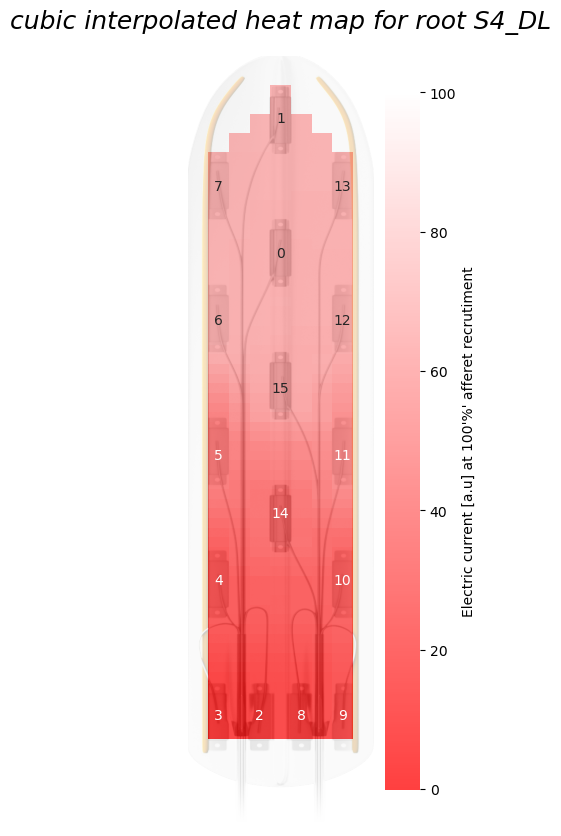

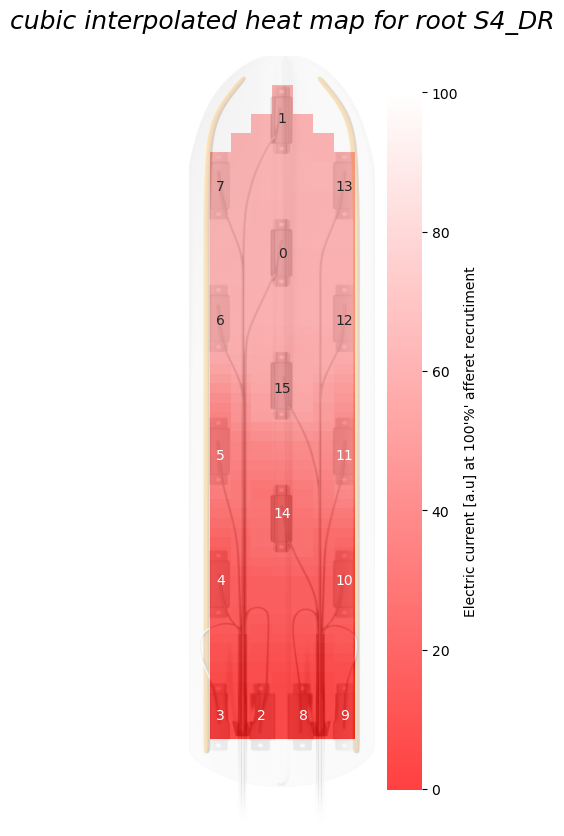

In [313]:

get_heat_map_individual_msc_with_interpolation(save_fig=1, folder_name="heatmap/roots")

# Fit sigmoid

In [332]:
from scipy.optimize import curve_fit

In [ ]:
## Sergio version all muscles 
from matplotlib import pylab
from pylab import *


In [324]:
def sigmoid(x, L ,x0, k, b):
    """
    A function to create calculate sigmoid curve.

    Parameters
    ----------
    L 
        is responsible for scaling the output range from [0,1] to [0,L]
    b 
        adds bias to the output and changes its range from [0,L] to [b,L+b]
    k 
        is responsible for scaling the input, which remains in (-inf,inf)
    x0 
        is the point in the middle of the Sigmoid, i.e. the point where Sigmoid should originally output the value 1/2 [since if x=x0, we get 1/(1+exp(0)) = 1/2].
     """
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

In [323]:
len(roots)

20

In [351]:
#electrode, root, 
def fit_sigmoid_max_value(electrodes_from_listing=electrodes_from_listing, roots=roots):
    """
    elec_i
        string or int, sigmoid curves for which electrode
    roots
        hjlhljh
    """
    # for electrode in electrodes_from_listing:
    for electrode in range (len(electrodes_from_listing)):
        # creating subplot
        fig, ax = plt.subplots(figsize=(10,7))
        for root in roots:
    
            ## assuming  
            ydata=recruitment_simulation[f"_{electrodes_from_listing[electrode]}_{root}"]["Recruitment"]
            xdata=np.arange(0, len(ydata))
            

            ## Initial guess for the parameters ##

            # maximum=1 # The maximum asymptotic intensity.
            # midpoint=np.max(xdata) # The time point at which the sigmoidal curve reaches half of its maximum intensity.
            # slope =0.5 # The slope of the curve at the midpoint.
            # # p0 = [maximum, midpoint,slope] # this is an mandatory initial guess
            p0 =[max(ydata), np.median(xdata),1/2,min(ydata)]



            popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox', maxfev=10000)
            print(f"opt:{popt}")
            print(f"pcov:{pcov}")
            x = np.linspace(0, 100, 100)
            y = sigmoid(x, *popt)
            ax.plot(xdata, ydata, 
            'o',
            # color= "red", 
            linewidth=0.1)
            ax.plot(x,y,  label=root)

            plt.ylabel("Afferent recruitment [%]")
            


            # set ticks
            # ax.set_xticks(ticks=[])
            plt.xlabel("Electric current [a.u]")
            plt.legend(title="roots")
            plt.title(f"Fitting data to sigmoid for {electrodes_from_listing[electrode]} ")
            # fig, ax = plt.subplots(figsize=(10,7))

            # ax.set_xticks(ticks=np.linspace(start=0.2, stop=np.max(unique_amplitudes["amplitudes"])+0.1, endpoint=True, num=25))
        plt.show()

opt:[ 1.06693797 16.69362947  0.20459803 -0.06637068]
pcov:[[ 6.74595496e-05 -7.58350270e-04 -2.38596261e-05 -6.28295400e-05]
 [-7.58350270e-04  1.43059192e-02  2.62899717e-04  7.66382936e-04]
 [-2.38596261e-05  2.62899717e-04  1.43061618e-05  2.19718127e-05]
 [-6.28295400e-05  7.66382936e-04  2.19718127e-05  6.07646637e-05]]
opt:[ 1.09919361 18.49576008  0.16290326 -0.09720729]
pcov:[[ 1.58172737e-04 -2.10465380e-03 -3.99410351e-05 -1.46879867e-04]
 [-2.10465380e-03  4.21609873e-02  5.18023465e-04  2.10425121e-03]
 [-3.99410351e-05  5.18023465e-04  1.55232808e-05  3.65465767e-05]
 [-1.46879867e-04  2.10425121e-03  3.65465767e-05  1.41055168e-04]]
opt:[ 1.11675832 17.16612453  0.15232594 -0.11666461]
pcov:[[ 2.71773054e-04 -3.82094997e-03 -5.69123224e-05 -2.56079804e-04]
 [-3.82094997e-03  7.10789728e-02  7.82571311e-04  3.78386840e-03]
 [-5.69123224e-05  7.82571311e-04  1.71676062e-05  5.28448949e-05]
 [-2.56079804e-04  3.78386840e-03  5.28448949e-05  2.46823275e-04]]
opt:[ 1.06724121

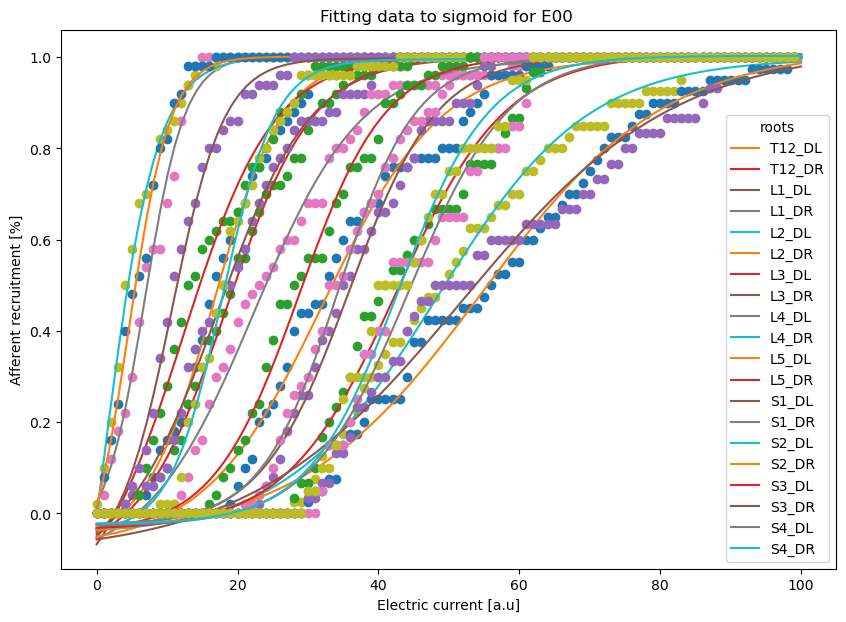

opt:[ 1.90655667  0.90248788  0.16781265 -0.90628512]
pcov:[[ 2.81439287e-02 -1.65698085e-01 -1.03863408e-03 -2.80549229e-02]
 [-1.65698085e-01  9.84079222e-01  6.26384721e-03  1.65195688e-01]
 [-1.03863408e-03  6.26384721e-03  4.50670739e-05  1.03380340e-03]
 [-2.80549229e-02  1.65195688e-01  1.03380340e-03  2.79696824e-02]]
opt:[ 1.24612170e+05 -8.45312223e+01  1.36834496e-01 -1.24611162e+05]
pcov:[[ 1.72845486e+12 -1.01608903e+08 -3.55323767e+02 -1.72845486e+12]
 [-1.01608903e+08  5.98079715e+03  3.28387994e-02  1.01608903e+08]
 [-3.55323767e+02  3.28387994e-02  1.88506990e-05  3.55323759e+02]
 [-1.72845486e+12  1.01608903e+08  3.55323759e+02  1.72845486e+12]]
opt:[ 1.34322332  2.20388026  0.46606505 -0.34295346]
pcov:[[ 0.00127466 -0.00463003 -0.00035206 -0.00127041]
 [-0.00463003  0.01731669  0.00130432  0.00461897]
 [-0.00035206  0.00130432  0.00012166  0.00035036]
 [-0.00127041  0.00461897  0.00035036  0.00126676]]
opt:[ 1.64497688  2.32980834  0.24260296 -0.64362143]
pcov:[[ 1.

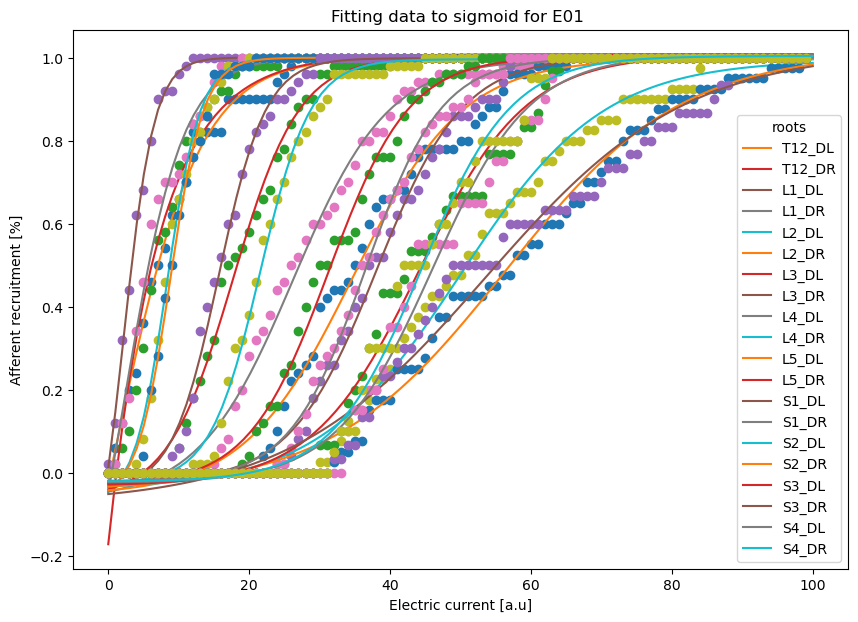

opt:[ 1.04846624 49.68376511  0.08685788 -0.05695584]
pcov:[[ 5.11971116e-04  1.16934378e-04 -8.68264344e-05 -2.54086200e-04]
 [ 1.16934378e-04  3.37097053e-01 -1.77261097e-05  3.38535813e-03]
 [-8.68264344e-05 -1.77261097e-05  1.99239577e-05  4.31252919e-05]
 [-2.54086200e-04  3.38535813e-03  4.31252919e-05  1.79687885e-04]]
opt:[ 9.97361484e-01  6.18893920e+01  9.86201292e-02 -2.29455929e-02]
pcov:[[ 4.74752662e-04  6.26185495e-03 -9.31340378e-05 -1.28121800e-04]
 [ 6.26185495e-03  3.36787753e-01 -1.12805589e-03  7.89431624e-04]
 [-9.31340378e-05 -1.12805589e-03  2.63526826e-05  2.69186685e-05]
 [-1.28121800e-04  7.89431624e-04  2.69186685e-05  7.62574759e-05]]
opt:[ 1.0394305  25.61797483  0.19181586 -0.03419255]
pcov:[[ 1.21261182e-04 -1.21099980e-03 -4.87654807e-05 -1.01504088e-04]
 [-1.21099980e-03  4.44096725e-02  4.76231475e-04  1.34748951e-03]
 [-4.87654807e-05  4.76231475e-04  4.31359936e-05  4.04443304e-05]
 [-1.01504088e-04  1.34748951e-03  4.04443304e-05  9.61307759e-05]]


RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

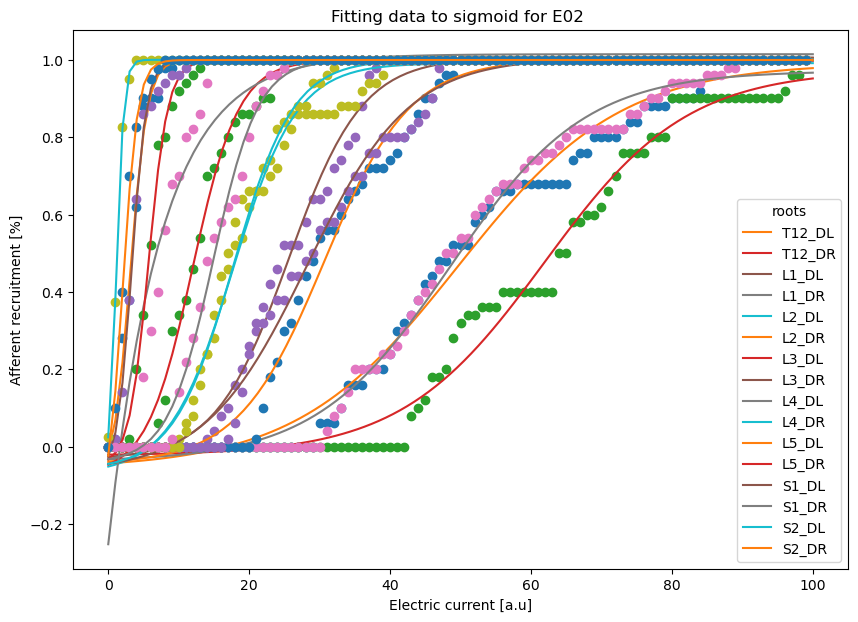

In [352]:
fit_sigmoid_max_value(electrodes_from_listing=electrodes_from_listing, roots=roots)

# For muscle i get info

## GUI 

- Heat map
- top 3 muscles activated by chosen elec
- muscle recruitment curve

### Get top three muslces for the elec

In [5]:
M=len(mt_muscles["muscle_name"])
N=len(mt_electrodes["elec_name"])

data=np.zeros((M,N))
for muscle_i in range(0, len(mt_muscles)):
    for elec_i in range (0, len(mt_electrodes)):
        ## Find max value for one combination
        max_value=np.nanmax(peak2peak_data_to_tensor[elec_i, muscle_i, :, 0, 0])
        ## Divide max value by amplitude at max value to normalise (not just between muscles but also between elecs)
        max_value_amplitude=amplitude_filtereddata_to_tensor[elec_i,muscle_i,np.where(max_value==peak2peak_data_to_tensor[elec_i, muscle_i, :, 0, 0])[0][0]]
        max_value_normalised=np.divide(max_value,max_value_amplitude)
        data[muscle_i][elec_i]=max_value_normalised

In [ ]:
def get_max_activation_for_elec(data, elec_i):
    """
    data
    A 2D numpy array of shape (M, N)
    elec_i
    int count for sepc electrode


    """
    sum_of_elec_i_activation=sum(data[:][elec_i])
    

In [ ]:
def get_top_3(data, elec_i), mt_muscles:
    """
    data
    A 2D numpy array of shape (M, N)
    elec_i
    int count for sepc electrode




    """
    #create return array 
    return_array=np.zeros((3, 2))
    # calculate sum of activation
    sum_of_elec_i_activation=sum(data[:][elec_i])
    #sort the array
    sorted_data = np.sort(data[:][elec_i])
   
   # get top 3 muscles acitvated by the electrode
    round=0
    for index  in range(-1, -4, -1):
        
        max_v=sorted_data[index]
        id_max_v=np.where(np.array(data[:][elec_i])==max_v)
        return_array[round][0]=id_max_v
        return_array[round][1]=np.divide(max_v,  sum_of_elec_i_activation)
        round+=1

    #get percentage of sum for each value

    #retrun array with muscle name and percentage
    return()



In [53]:
elec_i=0
#create return array 
return_array=np.zeros((3, 2))
# calculate sum of activation
sum_of_elec_i_activation=sum(data[:][elec_i])
#sort the array
sorted_data = np.sort(data[:][elec_i])

round=0
for index  in range(-1, -4, -1):
    # the max, 2nd max and 3max value
    max_v=sorted_data[index]
    id_max_v=np.where(np.array(data[:][elec_i])==max_v)[0]
    return_array[round][0]=id_max_v
    return_array[round][1]=np.divide(max_v,  sum_of_elec_i_activation)
    round+=1

In [54]:
print(return_array)

[[15.          0.29722463]
 [ 5.          0.23233217]
 [ 6.          0.12895107]]


In [56]:
data[:][0]

array([0.14650823, 0.05379957, 0.00254529, 0.00341275, 0.11728533,
       0.29029369, 0.16112138, 0.01580219, 0.00191608, 0.00198514,
       0.00222013, 0.01017808, 0.0034054 , 0.00280529, 0.06482307,
       0.37137532])

In [60]:
print(mt_muscles["muscle_name"][15])
print(mt_muscles["muscle_name"][5])
print(mt_muscles["muscle_name"][6])

RPS
RVL
LST


In [ ]:
    numbers=[1, 0, 15, 14]
    for index, number in enumerate(numbers, start=0):   # default is zero
        n=(14*index)+3 # equal spacing
        row=4
        e=number
        #save values to the indeces
        for i in range(6):
                paddle_lead[i+n][row] =data[muscle_i][e]

In [40]:
sorted_index_array = np.sort(data[:][0])
print(sorted_index_array[-1])

0.37137532234191895


In [41]:
np.where(np.array(data[:][elec_i])==sorted_index_array[-1])

(array([15]),)

In [ ]:
sns.heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None,
 robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, 
 linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, 
 xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)

In [115]:
unit="m/v"
c_bar_label=f"Muscle activation [{unit}]"  

/var/folders/4j/9km7ny0j44x89rh9lkzx_51m0000gn/T/ipykernel_84671/1880393179.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  text_box.set_val("Dataset: I will just right something")  # Trigger `submit` with the initial string.


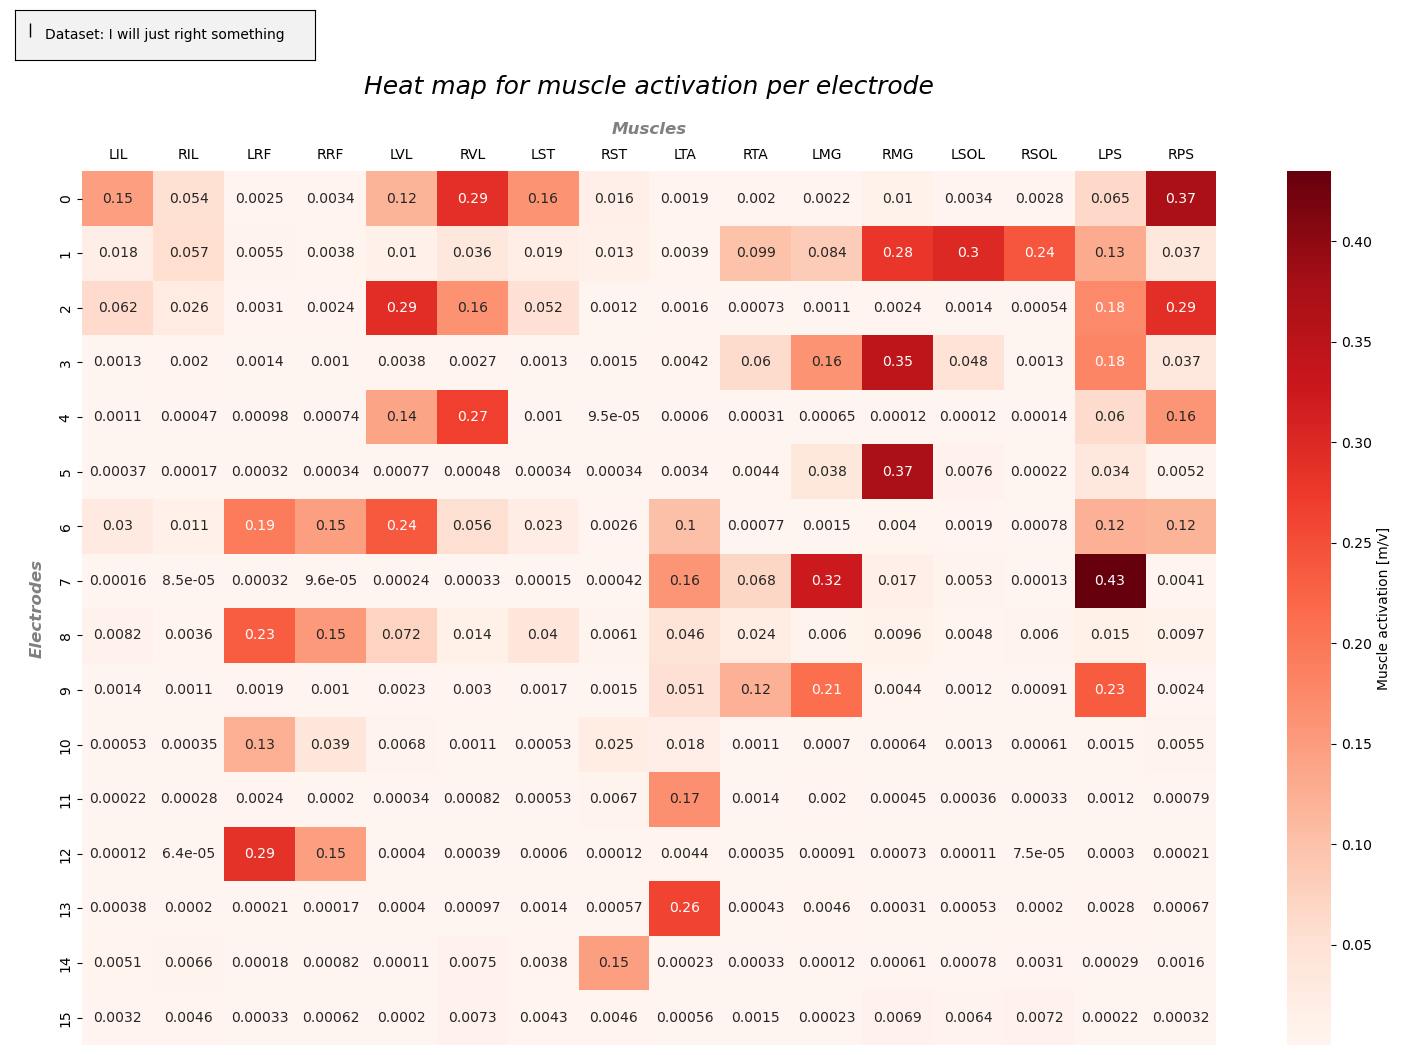

In [182]:
from matplotlib.widgets import TextBox

c_bar_label= f"Muscle activation [{unit}]"   
fig, ax = plt.subplots(figsize=(15,10))# creating subplot

sns.heatmap(data=data, cmap="Reds", cbar=True,
annot=True,  xticklabels=mt_muscles["muscle_name"],
yticklabels=mt_electrodes["elec_name"],
cbar_kws={'label': c_bar_label},
fmt='.2g' )
 # get the current axis;
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

ax.set_title('Heat map for muscle activation per electrode', size=18, fontstyle='italic', pad=20)
ax.set_xlabel('Muscles',  size=12, fontstyle='italic', labelpad=10, color="grey", fontweight="bold") 
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Electrodes', size=12, fontstyle='italic', labelpad=10, color="grey", fontweight="bold")
# fig.colorbar(cm.ScalarMappable( cmap="Reds"), ax=ax, shrink=0.5)
# fig.set_facecolor("black")


axbox = fig.add_axes([0, 1.0, 0.2, 0.05]) #[left, bottom, width, height]
text_box = TextBox(axbox,label=None, textalignment="center")
text_box.set_val("Dataset: I will just right something")  # Trigger `submit` with the initial string.

plt.show()
    

Create heat map with peak to peak / amp data

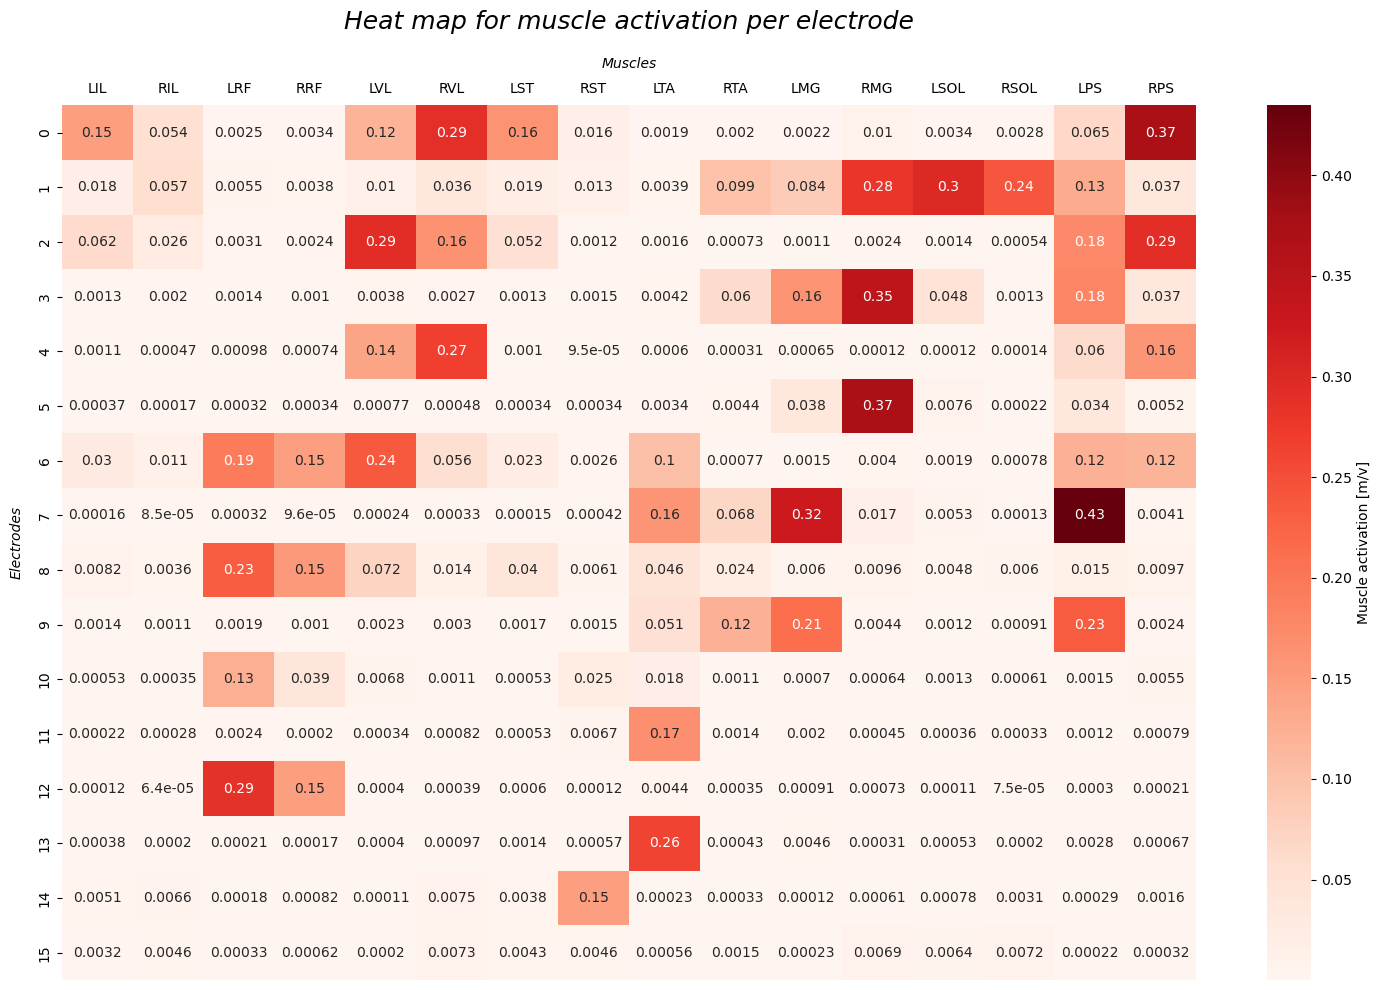

In [131]:
create_heatmap_all_muscles_overview(data=data, unit="m/v")